<a href="https://colab.research.google.com/github/Sahar-bgi/python/blob/main/Cause_of_Death.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [60]:
df=pd.read_csv("/content/annual-number-of-deaths-by-cause.csv")
df.head()

,Entity,Code,Year,Number of executions (Amnesty International),Deaths - Meningitis - Sex: Both - Age: All Ages (Number),Deaths - Neoplasms - Sex: Both - Age: All Ages (Number),"Deaths - Fire, heat, and hot substances - Sex: Both - Age: All Ages (Number)",Deaths - Malaria - Sex: Both - Age: All Ages (Number),Deaths - Drowning - Sex: Both - Age: All Ages (Number),Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Number),Deaths - HIV/AIDS - Sex: Both - Age: All Ages (Number),Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number),Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number),Deaths - Road injuries - Sex: Both - Age: All Ages (Number),Deaths - Maternal disorders - Sex: Both - Age: All Ages (Number),Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number),Deaths - Neonatal disorders - Sex: Both - Age: All Ages (Number),Deaths - Alcohol use disorders - Sex: Both - Age: All Ages (Number),Deaths - Exposure to forces of nature - Sex: Both - Age: All Ages (Number),Deaths - Diarrheal diseases - Sex: Both - Age: All Ages (Number),Deaths - Environmental heat and cold exposure - Sex: Both - Age: All Ages (Number),Deaths - Nutritional deficiencies - Sex: Both - Age: All Ages (Number),Deaths - Self-harm - Sex: Both - Age: All Ages (Number),Deaths - Conflict and terrorism - Sex: Both - Age: All Ages (Number),Deaths - Diabetes mellitus - Sex: Both - Age: All Ages (Number),Deaths - Poisonings - Sex: Both - Age: All Ages (Number),Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number),Terrorism (deaths),Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Number),Deaths - Chronic kidney disease - Sex: Both - Age: All Ages (Number),Deaths - Chronic respiratory diseases - Sex: Both - Age: All Ages (Number),Deaths - Cirrhosis and other chronic liver diseases - Sex: Both - Age: All Ages (Number),Deaths - Digestive diseases - Sex: Both - Age: All Ages (Number),Deaths - Acute hepatitis - Sex: Both - Age: All Ages (Number),Deaths - Alzheimer's disease and other dementias - Sex: Both - Age: All Ages (Number),Deaths - Parkinson's disease - Sex: Both - Age: All Ages (Number)
0,Afghanistan,AFG,2007,15,2933.000,15925.000,481.000,393.000,2127.000,3657.000,148.000,252.000,4995.000,7425.000,4990.000,27672.000,23890.000,111.000,296.000,9320.000,57.000,2488.000,1310.000,8220.000,3189.000,513.000,2439.000,1199.000,53962.000,4490.000,7222.000,3346.000,6458.000,3437.000,1402.000,450.000
1,Afghanistan,AFG,2008,17,2731.000,16148.000,462.000,255.000,1973.000,3785.000,157.000,261.000,4790.000,7355.000,5020.000,25800.000,23792.000,114.000,1317.000,8275.000,57.000,2277.000,1330.000,6895.000,3261.000,495.000,2231.000,1092.000,54051.000,4534.000,7143.000,3316.000,6408.000,3005.000,1424.000,455.000
2,Afghanistan,AFG,2009,0,2460.000,16383.000,448.000,239.000,1852.000,3874.000,167.000,270.000,4579.000,7290.000,5013.000,24340.000,23672.000,115.000,101.000,7359.000,57.000,2040.000,1342.000,7617.000,3336.000,483.000,1998.000,1065.000,53964.000,4597.000,7045.000,3291.000,6358.000,2663.000,1449.000,460.000
3,Afghanistan,AFG,2011,2,2327.000,17094.000,448.000,390.000,1775.000,4170.000,184.000,292.000,4259.000,7432.000,4857.000,22883.000,23951.000,120.000,83.000,6412.000,58.000,1846.000,1391.000,9142.000,3550.000,483.000,1805.000,1525.000,54347.000,4785.000,6916.000,3318.000,6370.000,2365.000,1508.000,473.000
4,Afghanistan,AFG,2012,14,2254.000,17522.000,445.000,94.000,1716.000,4245.000,191.000,305.000,4122.000,7494.000,4736.000,22162.000,24057.000,123.000,333.000,6008.000,103.000,1705.000,1413.000,11350.000,3682.000,482.000,1667.000,3521.000,54868.000,4846.000,6878.000,3353.000,6398.000,2264.000,1544.000,482.000


In [61]:
def dataset_sum(data, head=5):
    print("##################### Shape #####################")
    print(f"Number of rows: {data.shape[0]}")
    print(f"Number of columns: {data.shape[1]}")

    print("##################### Types #####################")
    print(data.dtypes)

    print("##################### Head #####################")
    print(data.head(head))

    print("##################### Tail #####################")
    print(data.tail(head))

    print("##################### Null Control #####################")
    print(data.isnull().sum())

    print("##################### Quantiles #####################")
    print(data.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

    print("##################### Table description #####################")
    print(data.describe().T)

def allocating_variable_types(data, cat_th, car_th):
  #cat_th:int
  #categoric variable threshold value
  #car_th:int
  #Threshold value for cardinal variables
  #cat_var:list
  #categorical variable list
  #num_var:list
  #numeric variable list
  #car_var:list
  #categoric but cardinal variable list
  #cat_var + num_var + car_var = total number of variables

    num_but_cat = [i for i in data.columns if data[i].dtypes != "O" and data[i].nunique() < cat_th]

    car_var = [i for i in data.columns if data[i].dtypes == "O" and data[i].nunique() > car_th]

    num_var = [i for i in data.columns if data[i].dtypes != "O" and i not in num_but_cat]

    cat_var = [i for i in data.columns if data[i].dtypes == "O" and i not in car_var]

    cat_var = cat_var + num_but_cat

    print(f"Number of data set columns/variables: {data.shape[1]}")
    print(f"Dataset row/number of data: {data.shape[0]}")
    print("********************************************")
    print(f"Number of numeric variables of the dataset: {len(num_var)}")
    print(f"Dataset's numeric variables: {num_var}")
    print("********************************************")
    print(f"Number of categoric variables of the dataset: {len(cat_var)}")
    print(f"Categorical variables of the dataset: {cat_var}")
    print("********************************************")
    print(f"Number of cardinal variables of the dataset: {len(car_var)}")
    print(f"Cardinal variables of the dataset: {car_var}")
    print("********************************************")

    return cat_var, num_var, car_var

def numeric_sum(data, variable, plot=False, null_control=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(data[variable].describe(quantiles).T)

    if plot:
        data[variable].hist(bins=20)
        plt.xlabel(variable)
        plt.title(variable)
        plt.show(block=True)
    print("##########################################")

    if null_control:
        print(f"Null data count: {data[variable].isnull().sum()}")


In [ ]:
dataset_sum(df)

In [62]:
df.isnull().sum()
df.shape

(8254, 36)

In [63]:
df=df.drop(columns=['Terrorism (deaths)','Number of executions (Amnesty International)','Code'])
df=df.dropna()
df.isnull().sum()
df.shape

(8010, 33)

In [64]:
cat_val,num_val,car_val=allocating_variable_types(df,10,20)

Number of data set columns/variables: 33
Dataset row/number of data: 8010
********************************************
Number of numeric variables of the dataset: 32
Dataset's numeric variables: ['Year', 'Deaths - Meningitis - Sex: Both - Age: All Ages (Number)', 'Deaths - Neoplasms - Sex: Both - Age: All Ages (Number)', 'Deaths - Fire, heat, and hot substances - Sex: Both - Age: All Ages (Number)', 'Deaths - Malaria - Sex: Both - Age: All Ages (Number)', 'Deaths - Drowning - Sex: Both - Age: All Ages (Number)', 'Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Number)', 'Deaths - HIV/AIDS - Sex: Both - Age: All Ages (Number)', 'Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number)', 'Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number)', 'Deaths - Road injuries - Sex: Both - Age: All Ages (Number)', 'Deaths - Maternal disorders - Sex: Both - Age: All Ages (Number)', 'Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number)', 'Deaths - Neo

count   8010.000
mean    2004.500
std        8.656
min     1990.000
5%      1991.000
10%     1992.900
20%     1995.800
30%     1998.700
40%     2001.600
50%     2004.500
60%     2007.400
70%     2010.300
80%     2013.200
90%     2016.100
95%     2018.000
99%     2019.000
max     2019.000
Name: Year, dtype: float64


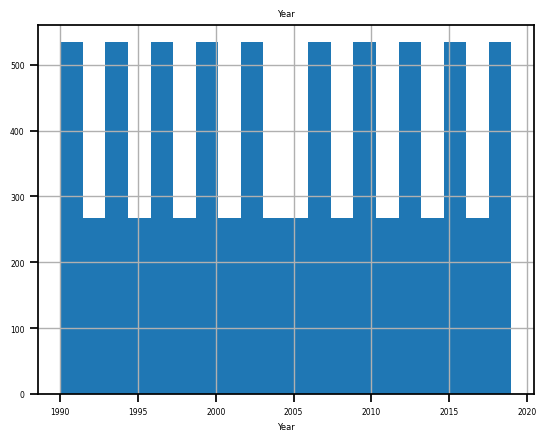

##########################################
Null data count: 0
count     8010.000
mean     12909.701
std      41799.388
min          0.000
5%           1.000
10%          3.000
20%         16.000
30%         44.700
40%        113.000
50%        294.000
60%        749.000
70%       2130.300
80%       4556.400
90%      24339.300
95%      99760.050
99%     200436.730
max     432524.000
Name: Deaths - Meningitis - Sex: Both - Age: All Ages (Number), dtype: float64


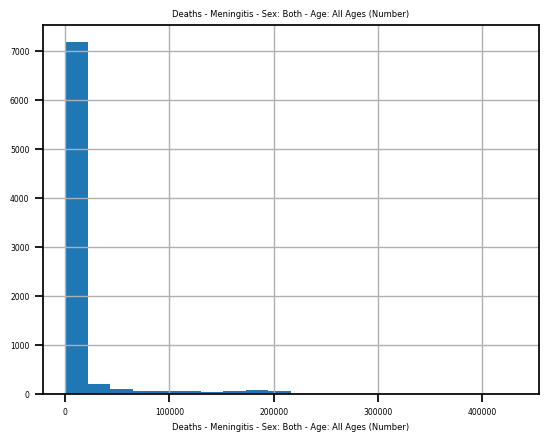

##########################################
Null data count: 0
count       8010.000
mean      298398.509
std       864390.100
min            1.000
5%            95.000
10%          171.000
20%          959.800
30%         3379.000
40%         5990.800
50%        10338.500
60%        21723.600
70%        52675.500
80%       178856.000
90%       839938.300
95%      2060472.550
99%      3954692.580
max     10079637.000
Name: Deaths - Neoplasms - Sex: Both - Age: All Ages (Number), dtype: float64


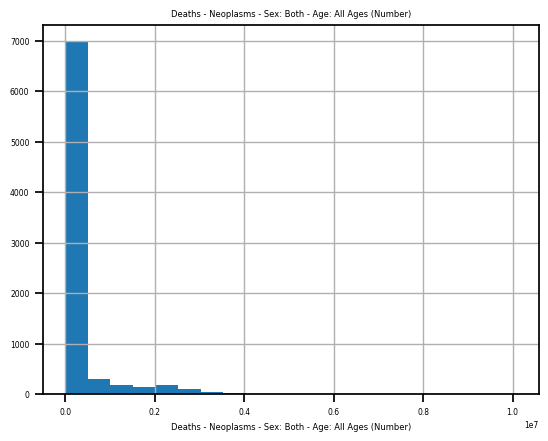

##########################################
Null data count: 0
count     8010.000
mean      4444.838
std      12111.914
min          0.000
5%           1.000
10%          3.000
20%         18.000
30%         56.000
40%        130.000
50%        244.000
60%        460.400
70%        818.000
80%       2650.600
90%      14879.900
95%      27425.000
99%      57071.500
max     129705.000
Name: Deaths - Fire, heat, and hot substances - Sex: Both - Age: All Ages (Number), dtype: float64


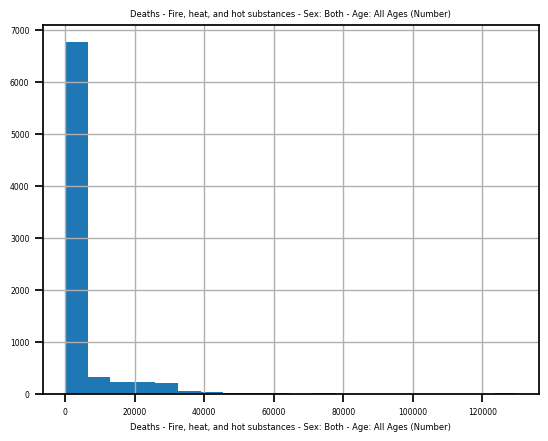

##########################################
Null data count: 0
count     8010.000
mean     31812.045
std     123035.872
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          1.000
60%         47.400
70%        889.300
80%       5751.600
90%      29527.900
95%     192561.200
99%     730914.910
max     961129.000
Name: Deaths - Malaria - Sex: Both - Age: All Ages (Number), dtype: float64


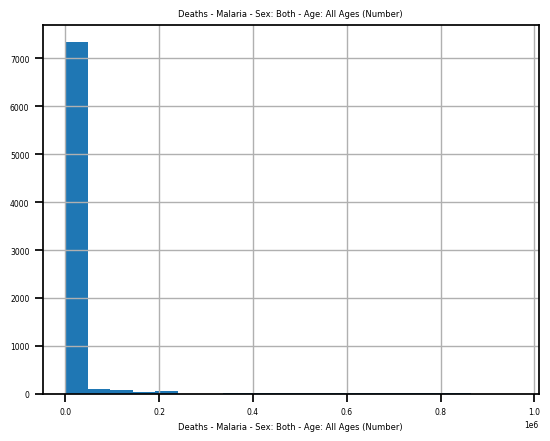

##########################################
Null data count: 0
count     8010.000
mean     12532.638
std      40095.991
min          0.000
5%           4.000
10%          8.000
20%         34.000
30%         87.000
40%        185.600
50%        393.500
60%        701.000
70%       1595.000
80%       6101.200
90%      28142.500
95%      85769.850
99%     199401.080
max     460665.000
Name: Deaths - Drowning - Sex: Both - Age: All Ages (Number), dtype: float64


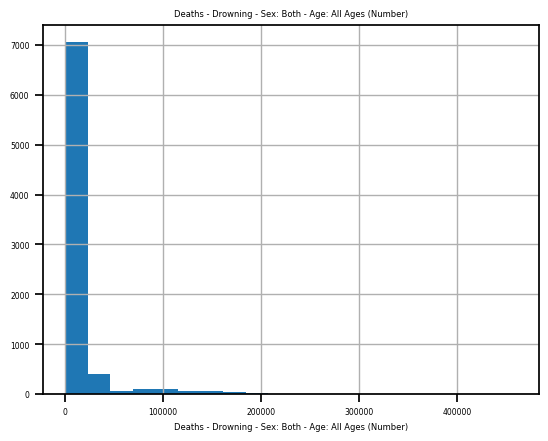

##########################################
Null data count: 0
count     8010.000
mean     15315.848
std      42888.545
min          0.000
5%           3.000
10%          7.000
20%         41.000
30%        134.000
40%        284.600
50%        494.000
60%        882.400
70%       2311.900
80%      12934.800
90%      53430.600
95%      82466.050
99%     216772.510
max     463129.000
Name: Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Number), dtype: float64


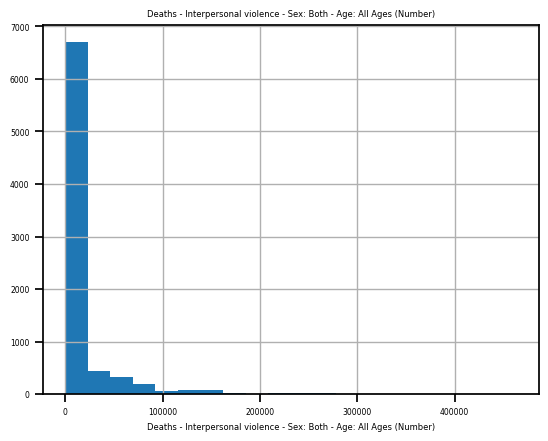

##########################################
Null data count: 0
count      8010.000
mean      47251.428
std      174479.778
min           0.000
5%            1.000
10%           3.000
20%          12.000
30%          51.000
40%         138.000
50%         420.000
60%        1537.800
70%        5061.800
80%       16737.000
90%       70214.400
95%      289463.000
99%      998167.000
max     1844490.000
Name: Deaths - HIV/AIDS - Sex: Both - Age: All Ages (Number), dtype: float64


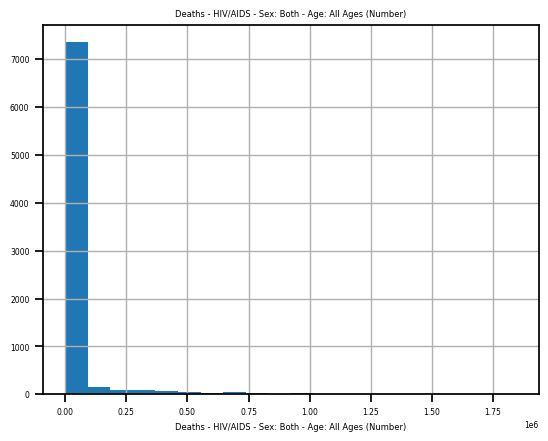

##########################################
Null data count: 0
count     8010.000
mean      3469.959
std      11186.515
min          0.000
5%           0.000
10%          1.000
20%          4.000
30%         10.000
40%         24.000
50%         57.000
60%        142.000
70%        299.000
80%       1068.200
90%       9356.000
95%      22285.650
99%      65192.120
max     128083.000
Name: Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number), dtype: float64


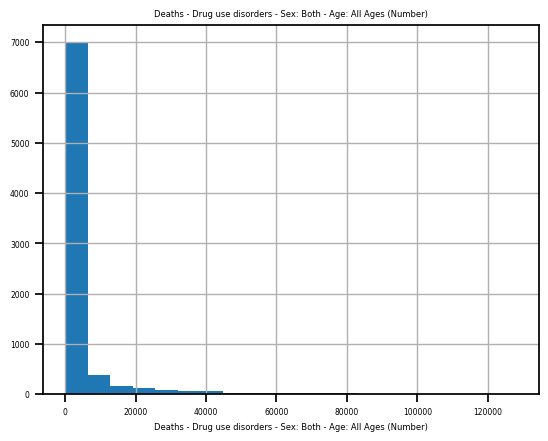

##########################################
Null data count: 0
count      8010.000
mean      56055.270
std      183787.627
min           0.000
5%            1.000
10%           6.000
20%          36.000
30%         105.000
40%         411.600
50%         956.000
60%        2442.200
70%        6581.500
80%       18946.400
90%      113221.300
95%      435117.200
99%      953460.770
max     1808478.000
Name: Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number), dtype: float64


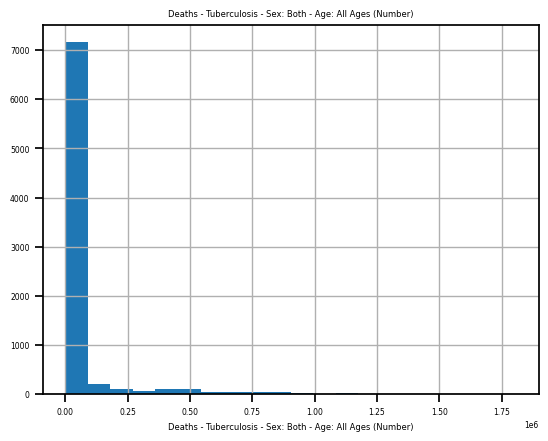

##########################################
Null data count: 0
count      8010.000
mean      44516.614
std      126907.671
min           0.000
5%            8.000
10%          21.000
20%         181.000
30%         501.700
40%        1021.000
50%        1969.500
60%        3507.000
70%        8273.100
80%       30169.400
90%      144552.100
95%      254791.550
99%      701699.500
max     1285039.000
Name: Deaths - Road injuries - Sex: Both - Age: All Ages (Number), dtype: float64


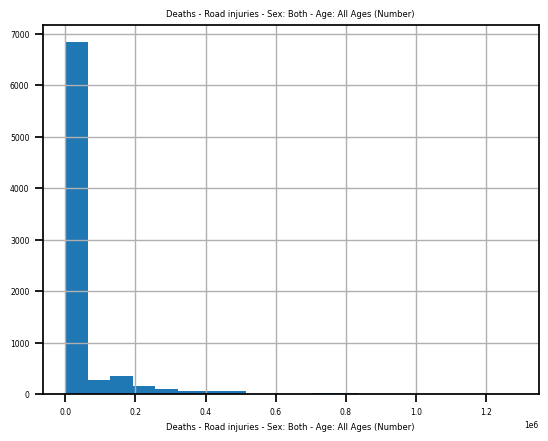

##########################################
Null data count: 0
count     8010.000
mean      9317.366
std      30665.565
min          0.000
5%           0.000
10%          1.000
20%          5.000
30%         16.000
40%         53.000
50%        163.000
60%        595.400
70%       1354.300
80%       2556.400
90%      16381.900
95%      79719.400
99%     151596.130
max     302586.000
Name: Deaths - Maternal disorders - Sex: Both - Age: All Ages (Number), dtype: float64


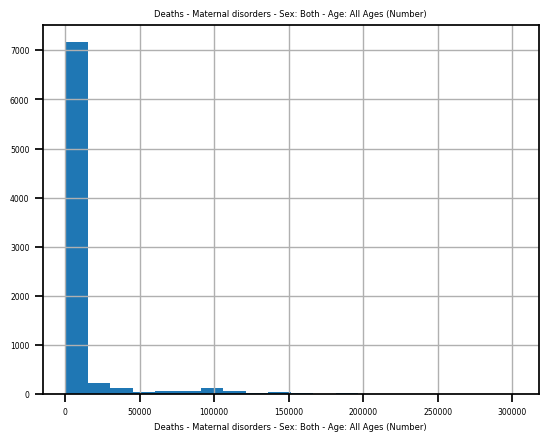

##########################################
Null data count: 0
count      8010.000
mean     104292.072
std      289786.533
min           0.000
5%           20.000
10%          47.000
20%         393.000
30%        1102.700
40%        2307.600
50%        5872.000
60%       10601.200
70%       21079.600
80%       70262.800
90%      307545.700
95%      705744.700
99%     1316163.150
max     3320008.000
Name: Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number), dtype: float64


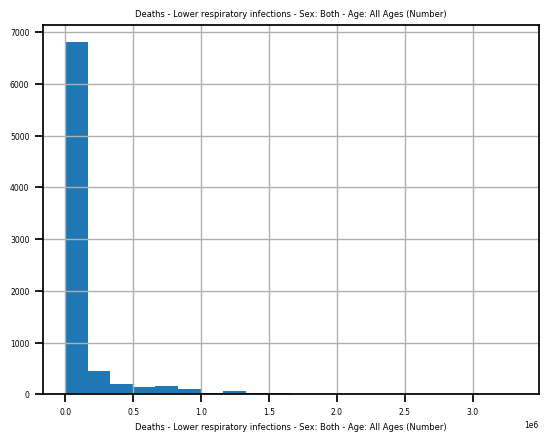

##########################################
Null data count: 0
count      8010.000
mean      92688.578
std      294717.483
min           0.000
5%            7.000
10%          22.000
20%         132.000
30%         365.000
40%         912.600
50%        2344.000
60%        6518.800
70%       14049.600
80%       32870.600
90%      203389.300
95%      746377.000
99%     1520339.010
max     3005945.000
Name: Deaths - Neonatal disorders - Sex: Both - Age: All Ages (Number), dtype: float64


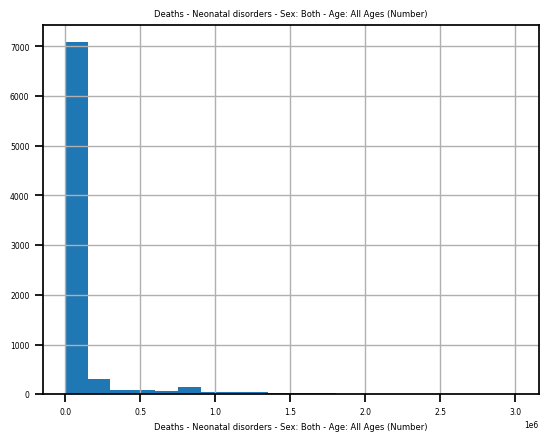

##########################################
Null data count: 0
count     8010.000
mean      6106.161
std      18455.074
min          0.000
5%           1.000
10%          3.000
20%         10.000
30%         39.000
40%         85.000
50%        172.000
60%        341.000
70%        733.000
80%       3004.800
90%      19859.800
95%      35513.600
99%      93081.150
max     181768.000
Name: Deaths - Alcohol use disorders - Sex: Both - Age: All Ages (Number), dtype: float64


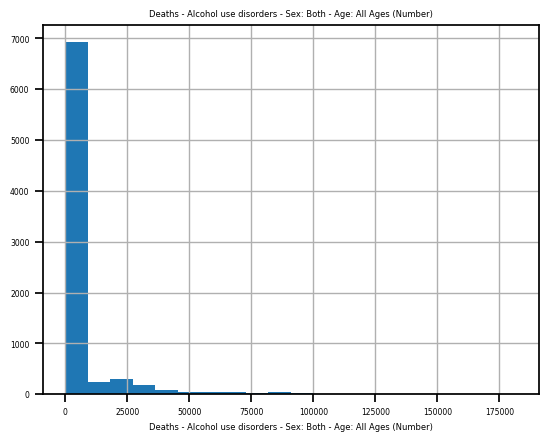

##########################################
Null data count: 0
count     8010.000
mean      1708.418
std      13834.348
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          2.000
60%         12.000
70%         45.000
80%        213.000
90%       1121.100
95%       3347.300
99%      29611.290
max     248861.000
Name: Deaths - Exposure to forces of nature - Sex: Both - Age: All Ages (Number), dtype: float64


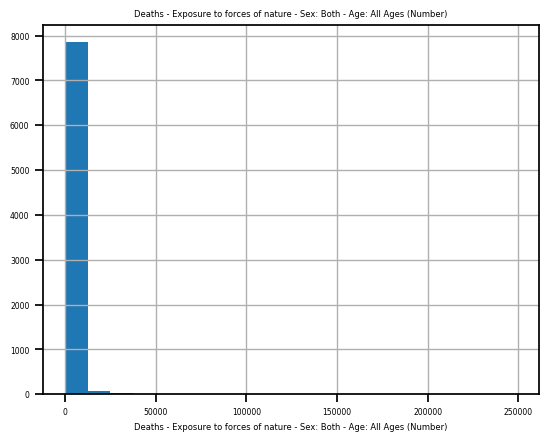

##########################################
Null data count: 0
count      8010.000
mean      81460.836
std      284379.559
min           0.000
5%            1.000
10%           4.000
20%          23.000
30%          83.000
40%         304.600
50%         992.500
60%        3088.400
70%        8305.700
80%       21143.200
90%      105920.700
95%      739165.350
99%     1461533.310
max     2904396.000
Name: Deaths - Diarrheal diseases - Sex: Both - Age: All Ages (Number), dtype: float64


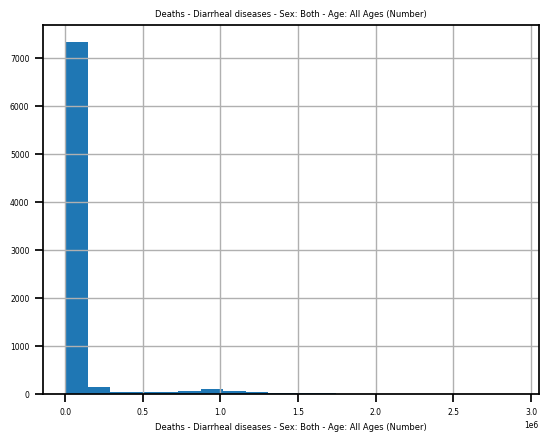

##########################################
Null data count: 0
count    8010.000
mean     2237.056
std      7179.057
min         0.000
5%          0.000
10%         0.000
20%         3.000
30%         9.000
40%        22.000
50%        55.000
60%       110.000
70%       192.000
80%       782.200
90%      5770.000
95%     13376.250
99%     38319.310
max     72653.000
Name: Deaths - Environmental heat and cold exposure - Sex: Both - Age: All Ages (Number), dtype: float64


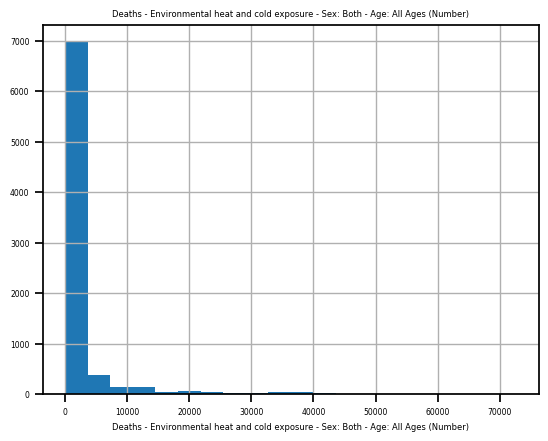

##########################################
Null data count: 0
count     8010.000
mean     16586.057
std      55468.631
min          0.000
5%           1.000
10%          3.000
20%          9.000
30%         30.000
40%        123.000
50%        291.000
60%       1000.800
70%       2876.200
80%       7734.000
90%      35265.600
95%     110667.800
99%     288473.120
max     757152.000
Name: Deaths - Nutritional deficiencies - Sex: Both - Age: All Ages (Number), dtype: float64


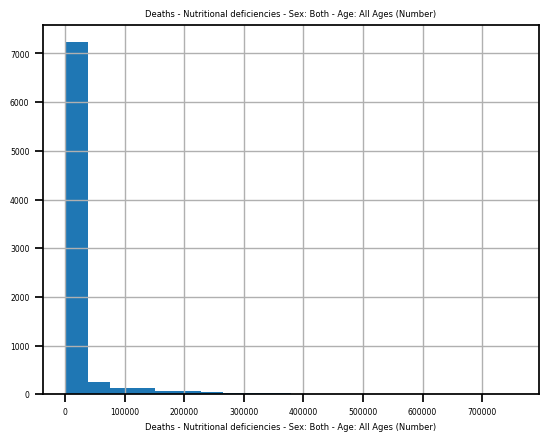

##########################################
Null data count: 0
count     8010.000
mean     30072.524
std      87229.918
min          0.000
5%           5.000
10%         16.000
20%        115.800
30%        303.000
40%        557.000
50%        995.000
60%       2016.400
70%       4427.600
80%      14474.000
90%      90881.000
95%     198526.650
99%     478431.590
max     841164.000
Name: Deaths - Self-harm - Sex: Both - Age: All Ages (Number), dtype: float64


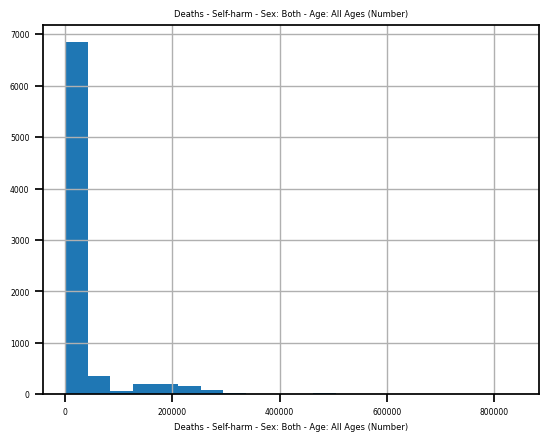

##########################################
Null data count: 0
count     8010.000
mean      3763.654
std      22982.886
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          3.000
60%         18.000
70%        114.000
80%        842.200
90%       5843.200
95%      16747.800
99%      74727.650
max     566518.000
Name: Deaths - Conflict and terrorism - Sex: Both - Age: All Ages (Number), dtype: float64


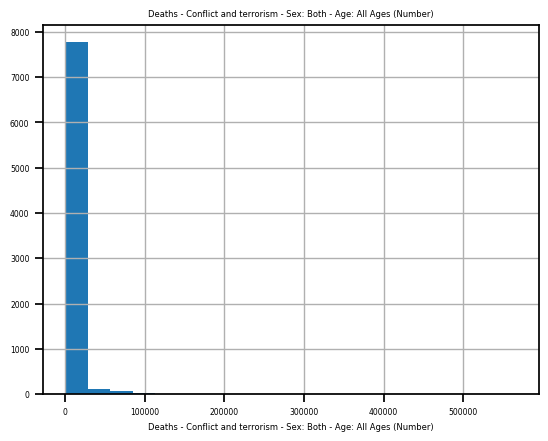

##########################################
Null data count: 0
count      8010.000
mean      39436.228
std      110983.158
min           1.000
5%           21.000
10%          64.000
20%         248.000
30%         583.000
40%        1135.200
50%        1894.000
60%        3293.200
70%        8842.900
80%       26350.800
90%      138398.100
95%      223051.350
99%      519282.630
max     1551170.000
Name: Deaths - Diabetes mellitus - Sex: Both - Age: All Ages (Number), dtype: float64


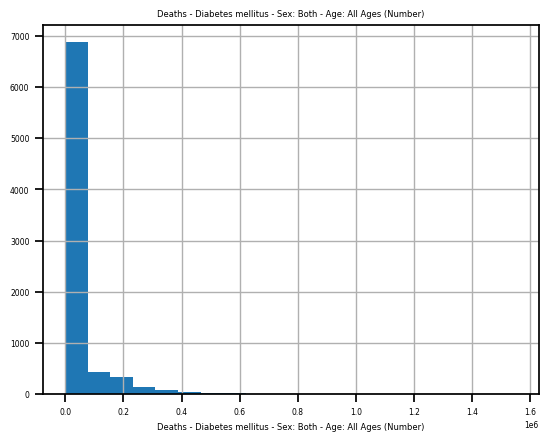

##########################################
Null data count: 0
count    8010.000
mean     3189.111
std      9180.095
min         0.000
5%          0.000
10%         1.000
20%         7.000
30%        22.000
40%        55.000
50%       125.000
60%       249.000
70%       459.300
80%      1455.400
90%     10448.500
95%     20961.950
99%     45065.640
max     92101.000
Name: Deaths - Poisonings - Sex: Both - Age: All Ages (Number), dtype: float64


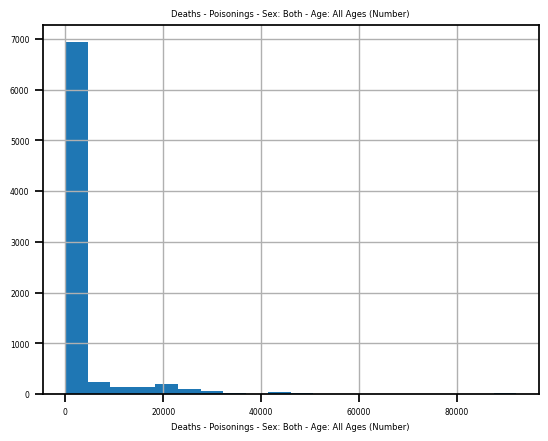

##########################################
Null data count: 0
count     8010.000
mean     14441.385
std      47987.721
min          0.000
5%           0.000
10%          2.000
20%          5.000
30%         19.000
40%         93.000
50%        233.500
60%        804.000
70%       2721.000
80%       7038.000
90%      31286.200
95%      94429.450
99%     242215.960
max     656314.000
Name: Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number), dtype: float64


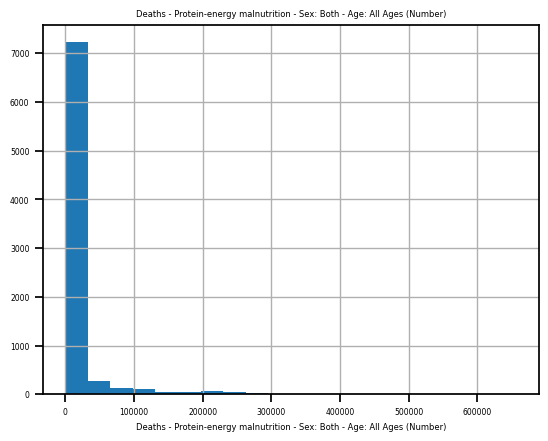

##########################################
Null data count: 0
count       8010.000
mean      567277.739
std      1606918.307
min            4.000
5%           160.000
10%          330.900
20%         2347.000
30%         6850.500
40%        12681.000
50%        23265.500
60%        46231.600
70%        98718.500
80%       330262.600
90%      1824269.100
95%      3599899.550
99%      7477443.170
max     18562510.000
Name: Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Number), dtype: float64


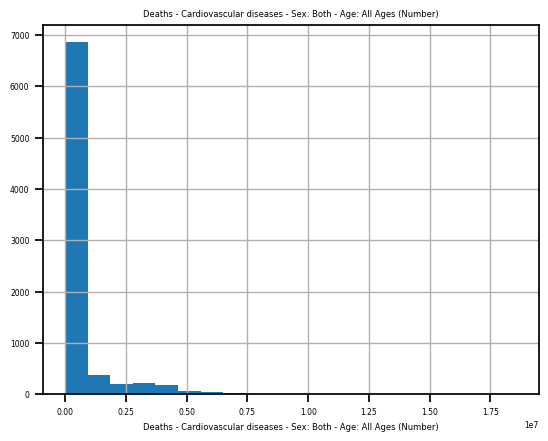

##########################################
Null data count: 0
count      8010.000
mean      36145.453
std      102878.751
min           0.000
5%           16.000
10%          39.000
20%         170.800
30%         452.700
40%         867.600
50%        1651.000
60%        3122.400
70%        7370.400
80%       23766.000
90%      117040.600
95%      212878.550
99%      472724.130
max     1427232.000
Name: Deaths - Chronic kidney disease - Sex: Both - Age: All Ages (Number), dtype: float64


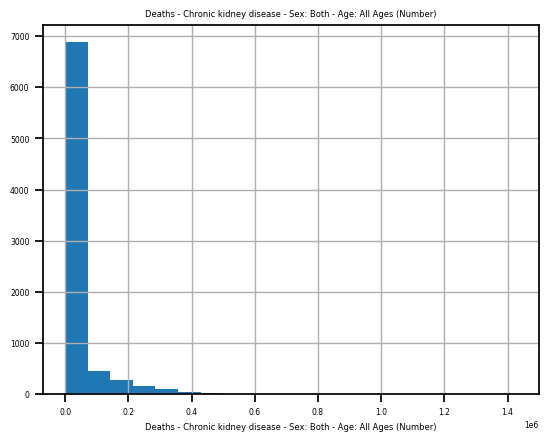

##########################################
Null data count: 0
count      8010.000
mean     131501.249
std      417492.384
min           1.000
5%           18.000
10%          49.000
20%         314.000
30%         877.000
40%        1861.600
50%        2960.500
60%        5982.400
70%       17614.500
80%       53103.800
90%      299161.900
95%     1041841.300
99%     2571690.320
max     3974315.000
Name: Deaths - Chronic respiratory diseases - Sex: Both - Age: All Ages (Number), dtype: float64


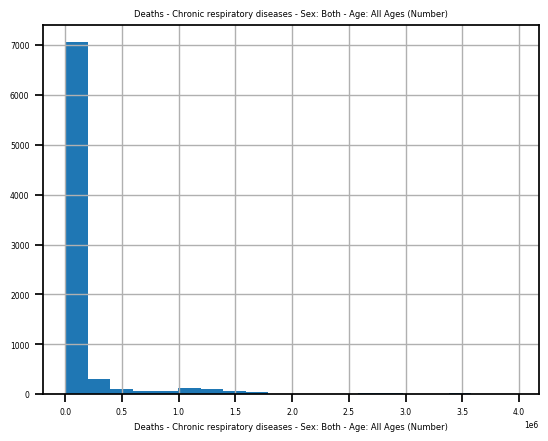

##########################################
Null data count: 0
count      8010.000
mean      46686.335
std      128238.259
min           0.000
5%           10.000
10%          25.000
20%         171.800
30%         500.400
40%        1247.000
50%        2134.000
60%        3659.800
70%        9093.100
80%       37046.400
90%      168307.300
95%      252279.950
99%      667790.650
max     1472012.000
Name: Deaths - Cirrhosis and other chronic liver diseases - Sex: Both - Age: All Ages (Number), dtype: float64


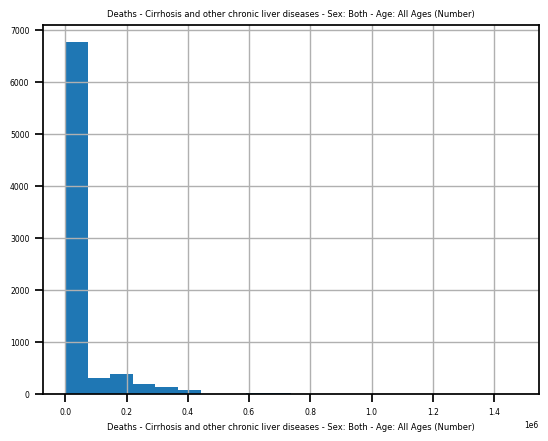

##########################################
Null data count: 0
count      8010.000
mean      82614.910
std      225355.434
min           0.000
5%           19.000
10%          47.000
20%         338.000
30%        1073.000
40%        2279.200
50%        4032.500
60%        6398.000
70%       17689.900
80%       62354.400
90%      303008.000
95%      462226.550
99%     1128301.950
max     2557689.000
Name: Deaths - Digestive diseases - Sex: Both - Age: All Ages (Number), dtype: float64


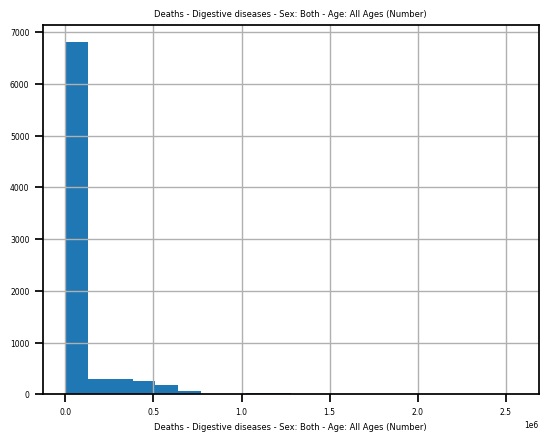

##########################################
Null data count: 0
count     8010.000
mean      4586.227
std      16692.426
min          0.000
5%           0.000
10%          0.000
20%          2.000
30%          6.000
40%         15.000
50%         47.000
60%        139.000
70%        309.000
80%        890.400
90%       7919.300
95%      25491.650
99%      91881.200
max     166405.000
Name: Deaths - Acute hepatitis - Sex: Both - Age: All Ages (Number), dtype: float64


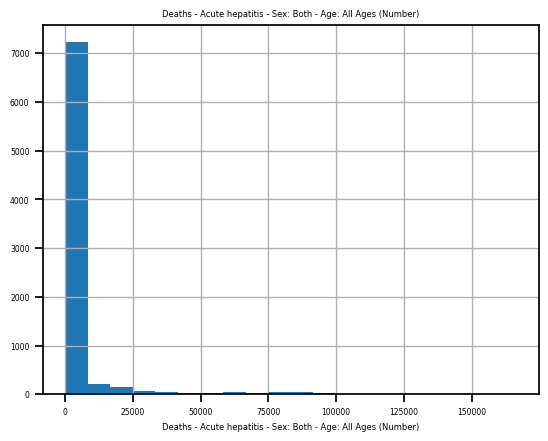

##########################################
Null data count: 0
count      8010.000
mean      39233.947
std      117977.213
min           0.000
5%            8.000
10%          18.000
20%         104.000
30%         358.000
40%         710.000
50%        1337.000
60%        2678.000
70%        6930.700
80%       25193.400
90%      115360.500
95%      249589.400
99%      579424.220
max     1623276.000
Name: Deaths - Alzheimer's disease and other dementias - Sex: Both - Age: All Ages (Number), dtype: float64


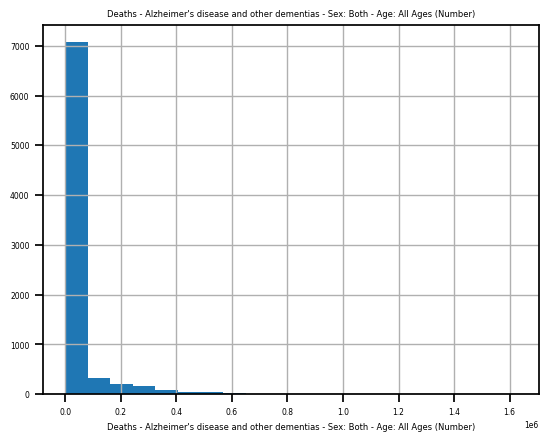

##########################################
Null data count: 0
count     8010.000
mean      9367.017
std      27358.718
min          0.000
5%           3.000
10%          6.000
20%         31.000
30%         93.000
40%        177.000
50%        331.000
60%        657.400
70%       1668.300
80%       5948.200
90%      29643.500
95%      60220.300
99%     122362.770
max     362907.000
Name: Deaths - Parkinson's disease - Sex: Both - Age: All Ages (Number), dtype: float64


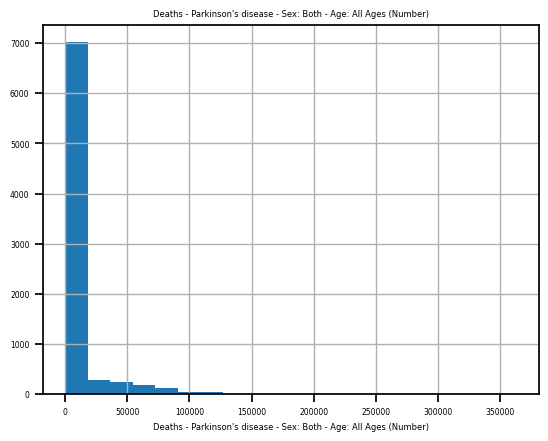

##########################################
Null data count: 0


In [65]:
for i in num_val:
    numeric_sum(df,i,True,True)

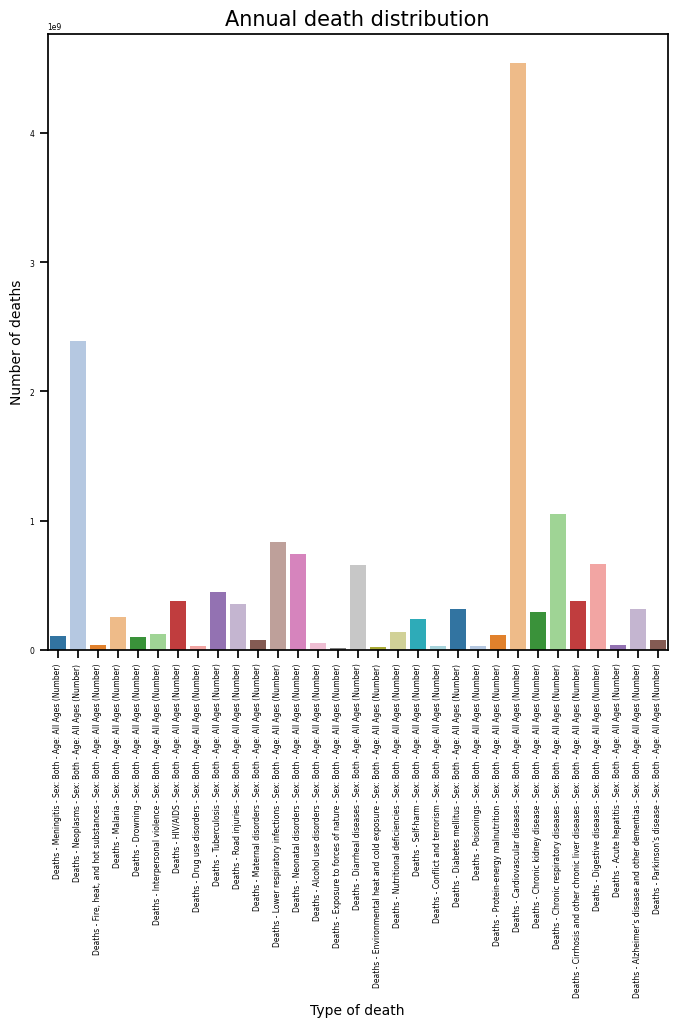

In [67]:
a=df.columns
a=a.drop(["Year","Entity"])


sns.set_context('notebook',font_scale=0.5)
plt.figure(figsize=(8,8))
sns.barplot(x=df[a].sum().index,y=df[a].sum().values,palette='tab20');
plt.title('Annual death distribution',size=15)
plt.ylabel('Number of deaths',size=10)
plt.xlabel('Type of death',size=10)
plt.xticks(rotation=90);

<ipython-input-69-b5aa66465d72>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


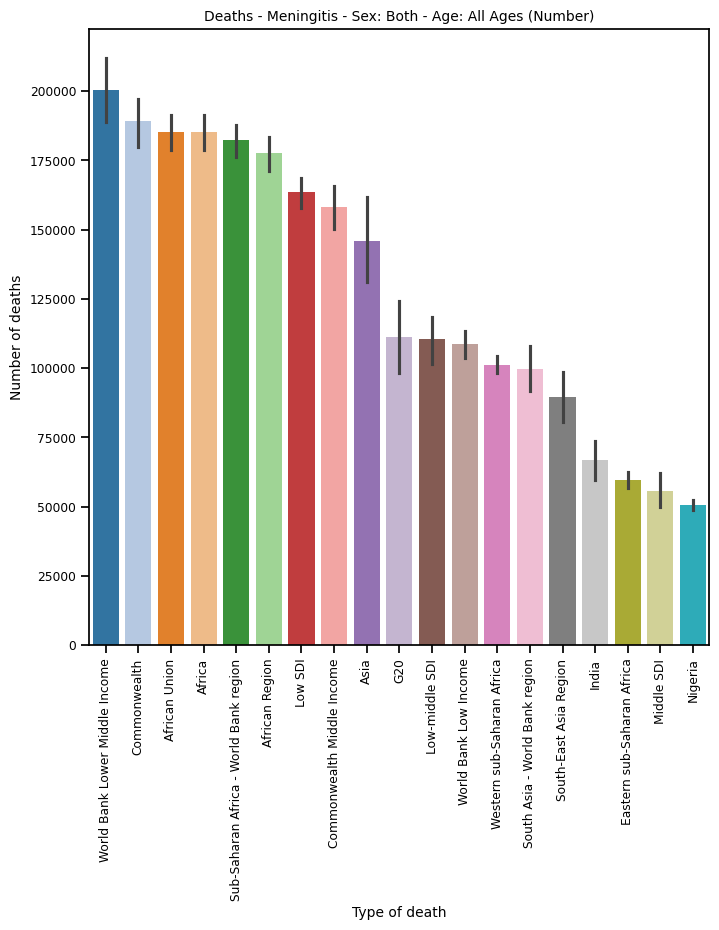

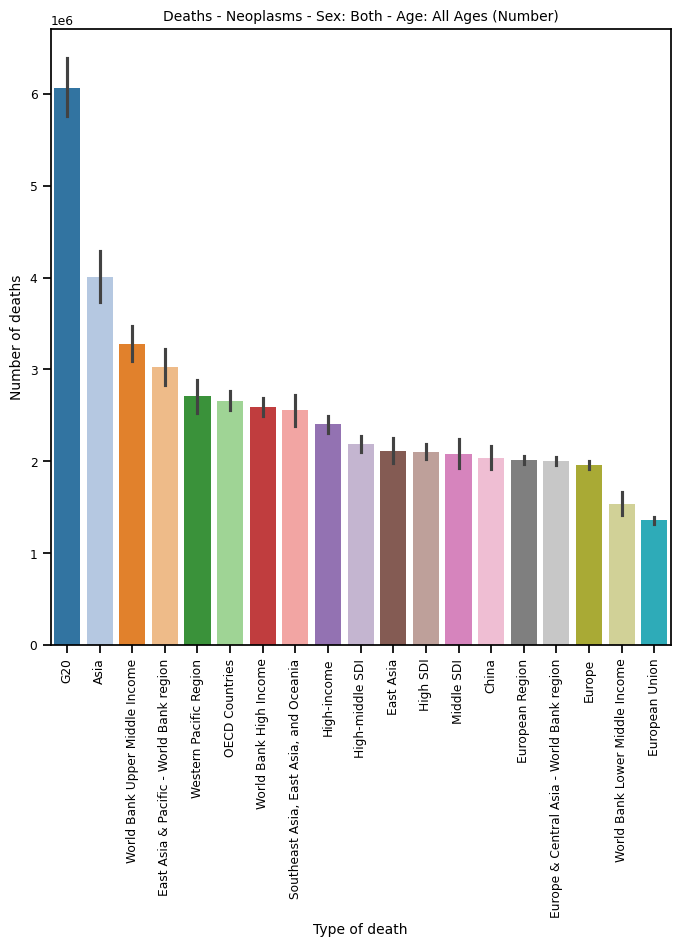

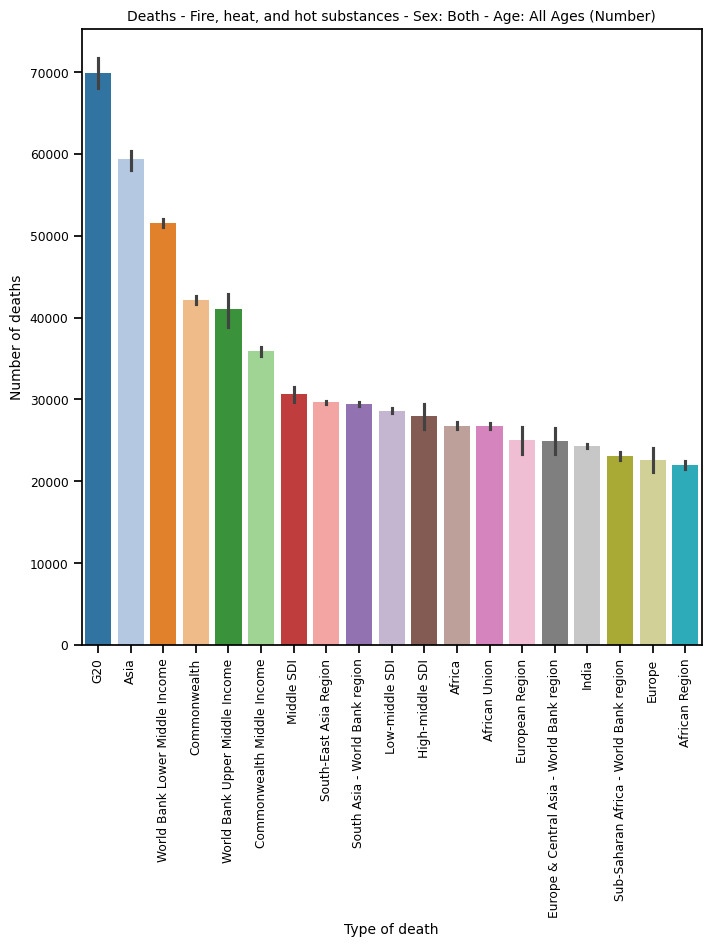

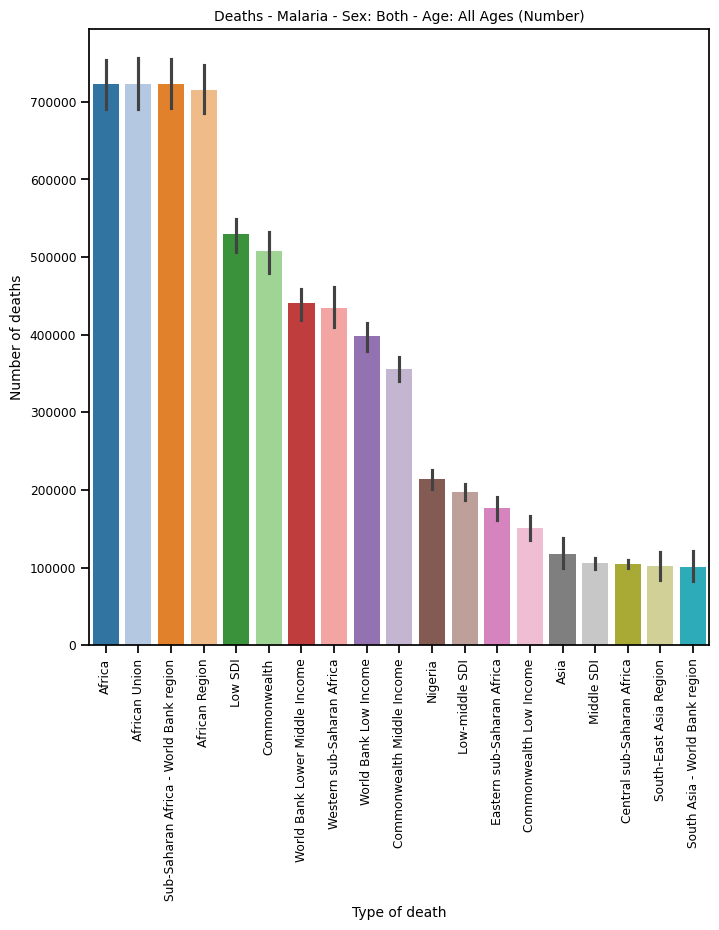

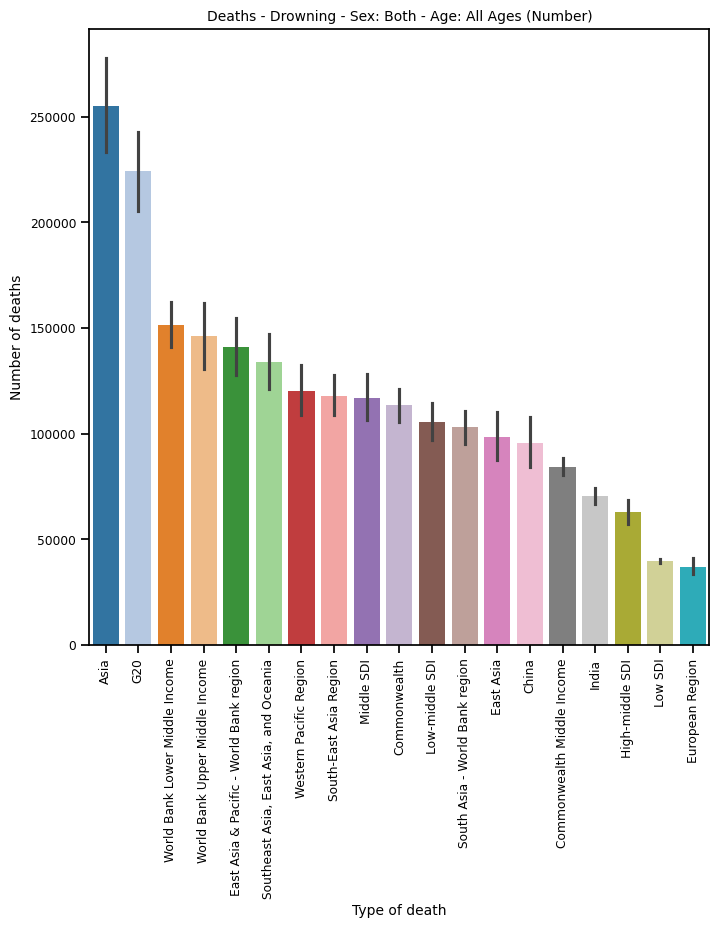

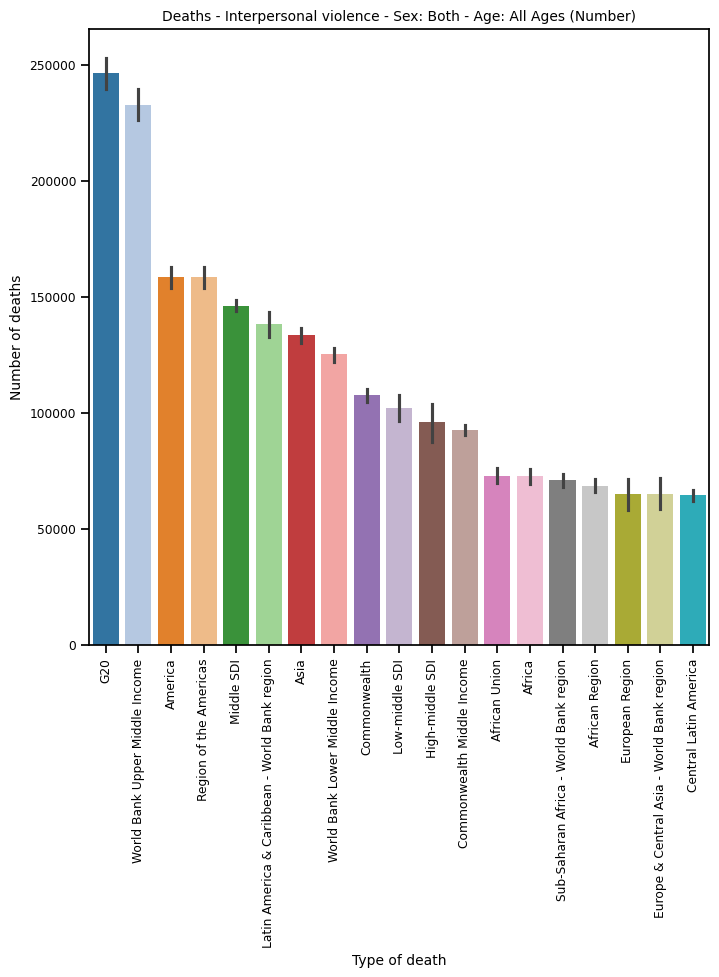

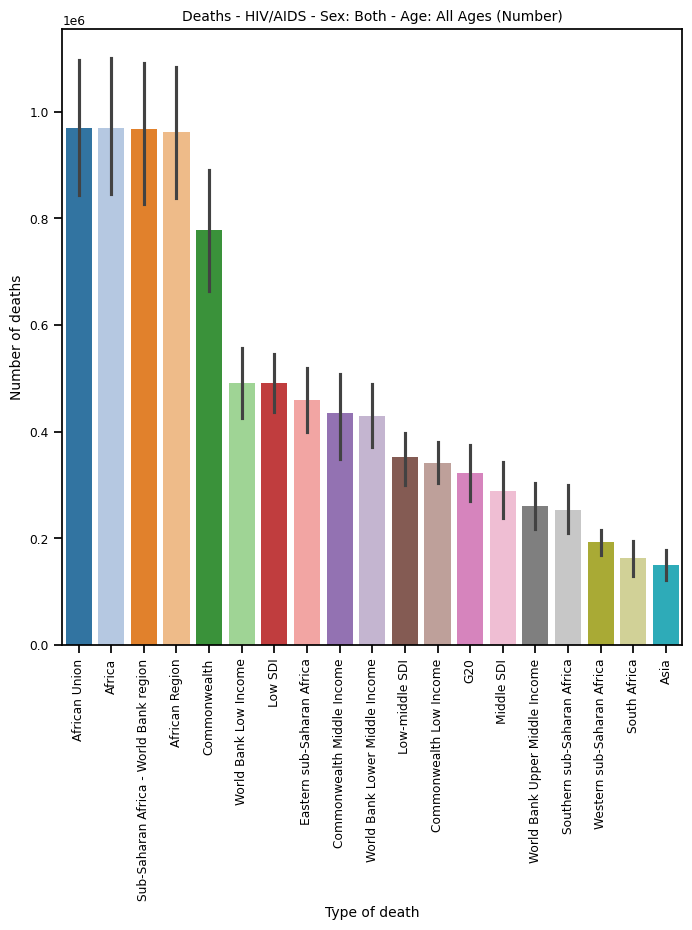

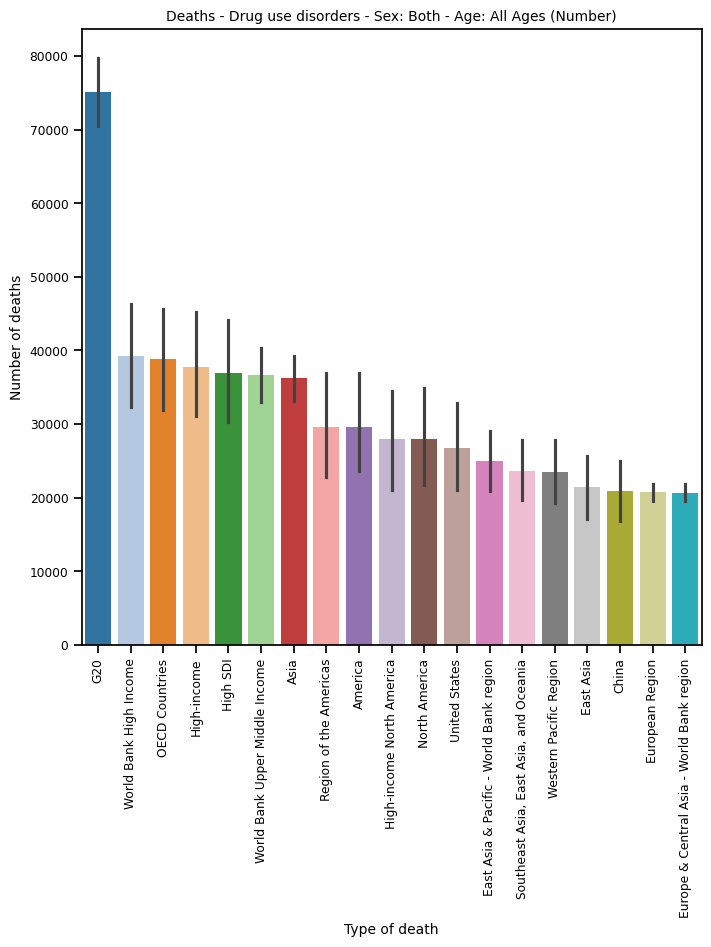

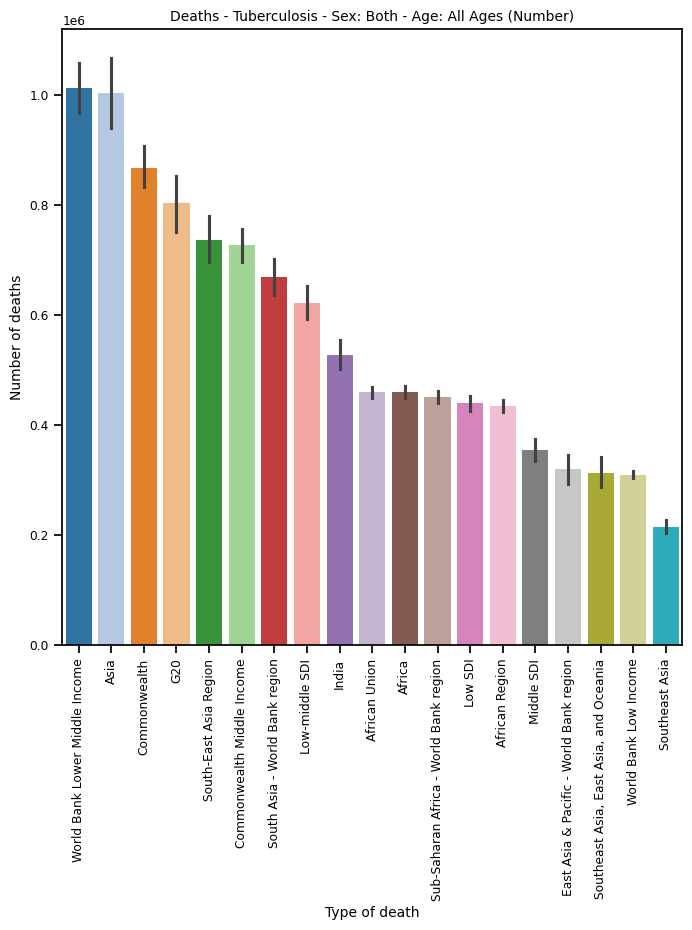

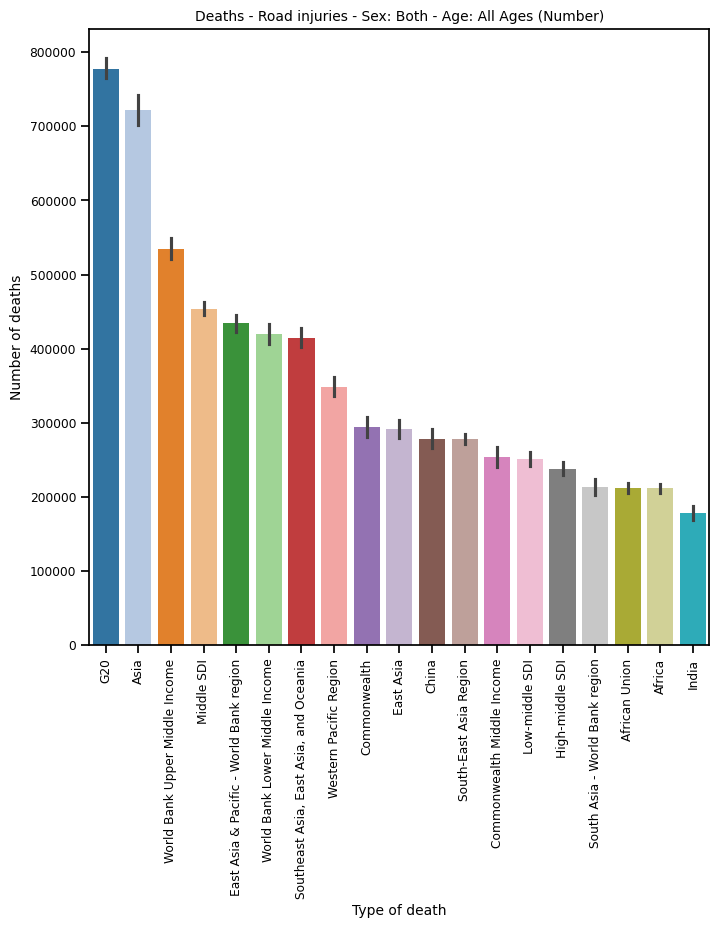

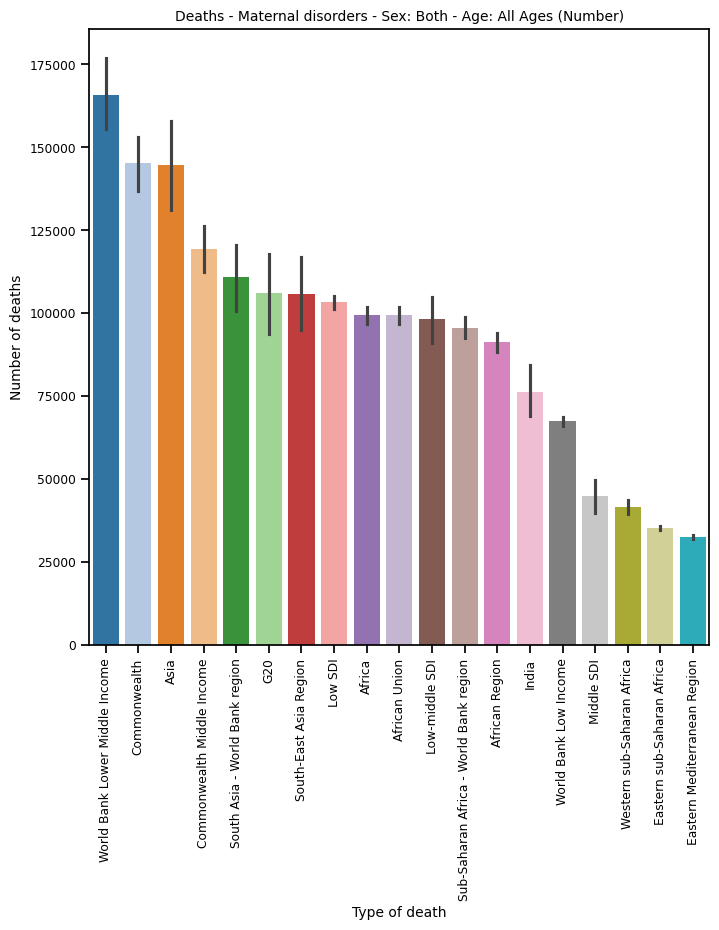

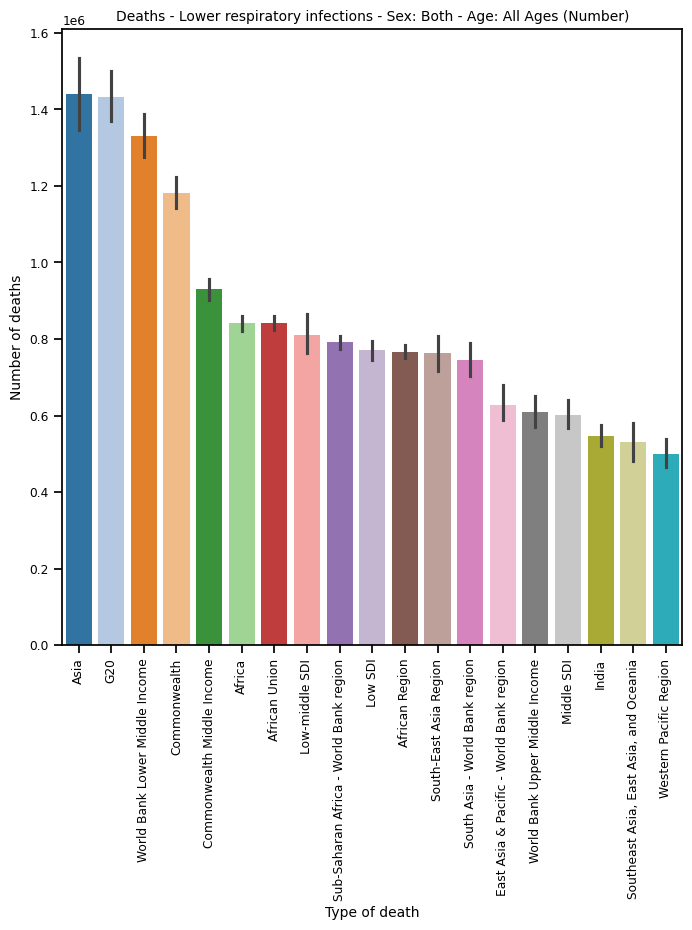

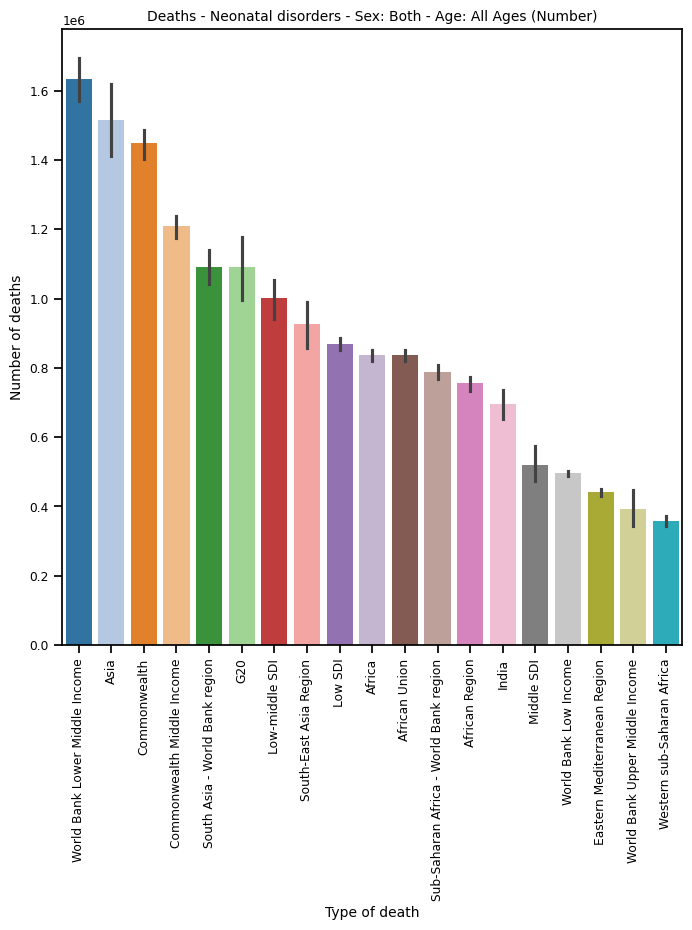

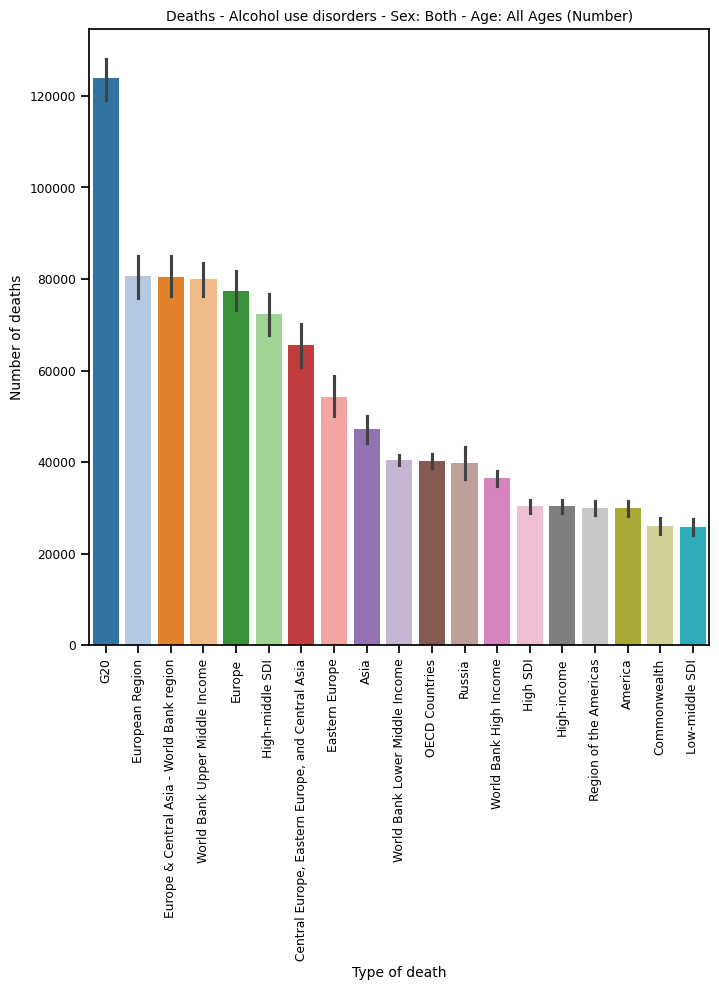

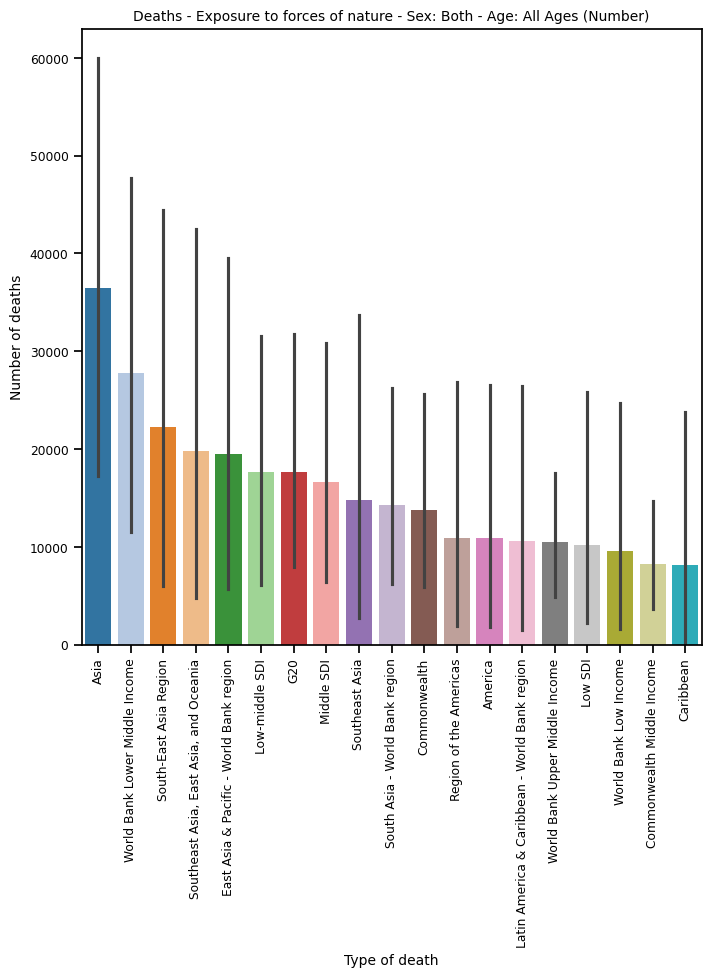

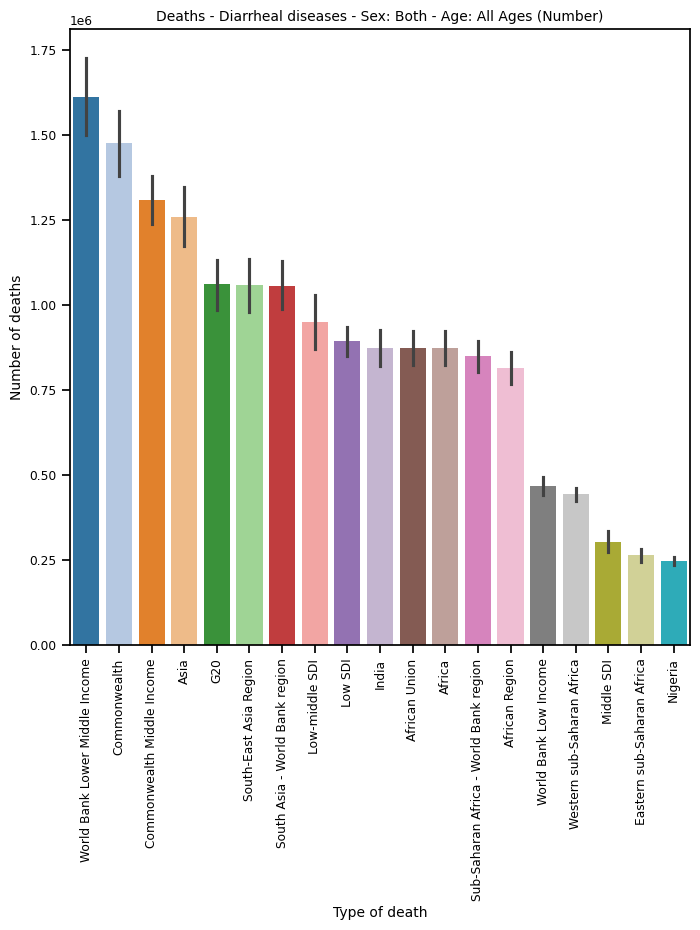

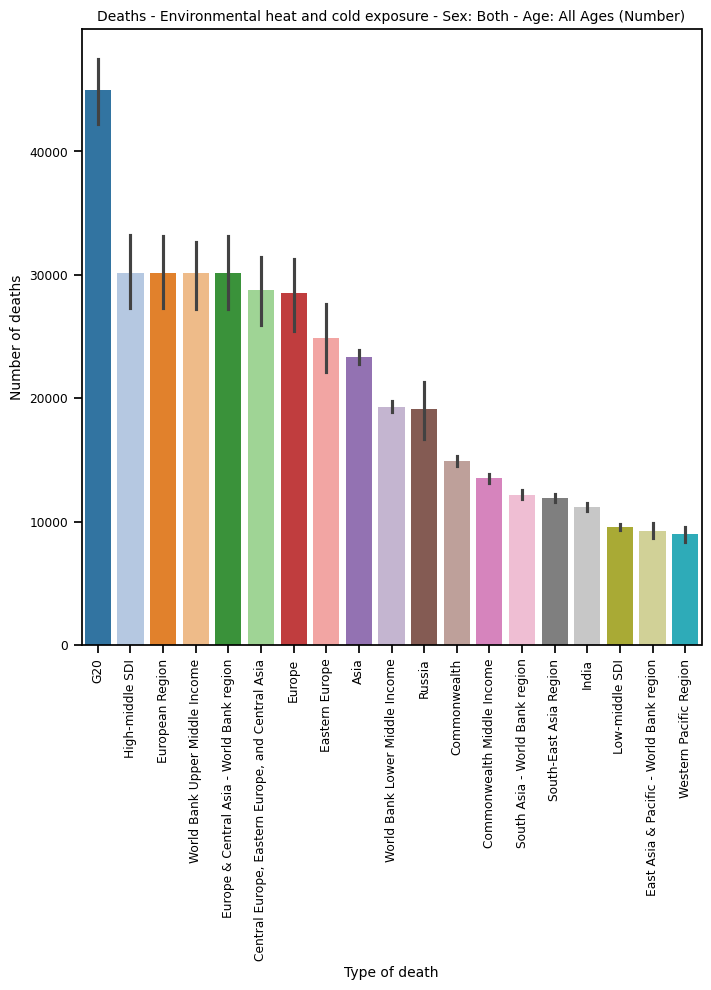

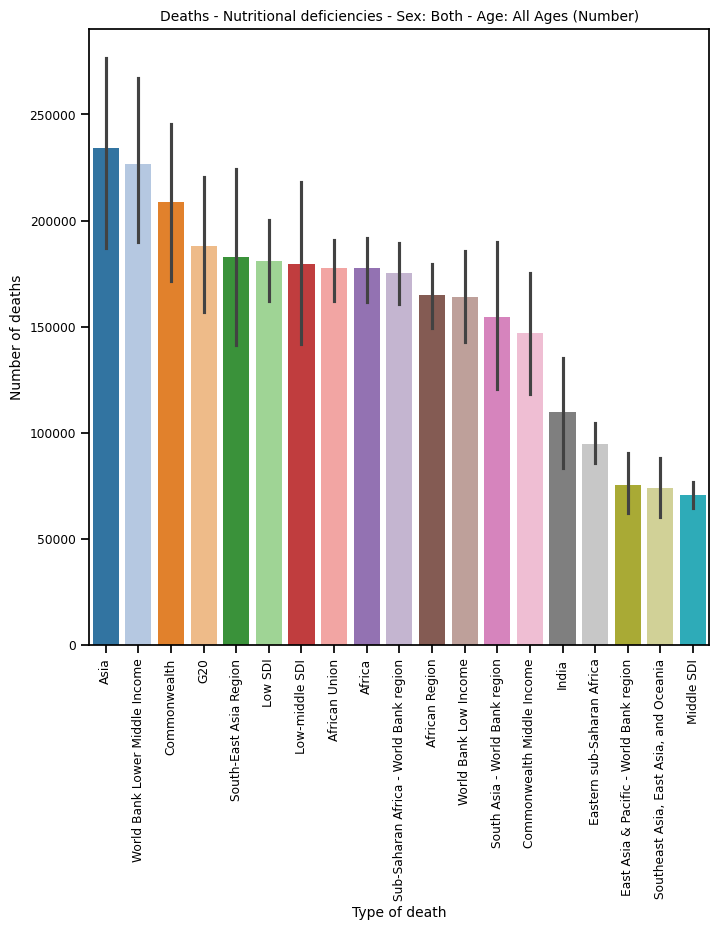

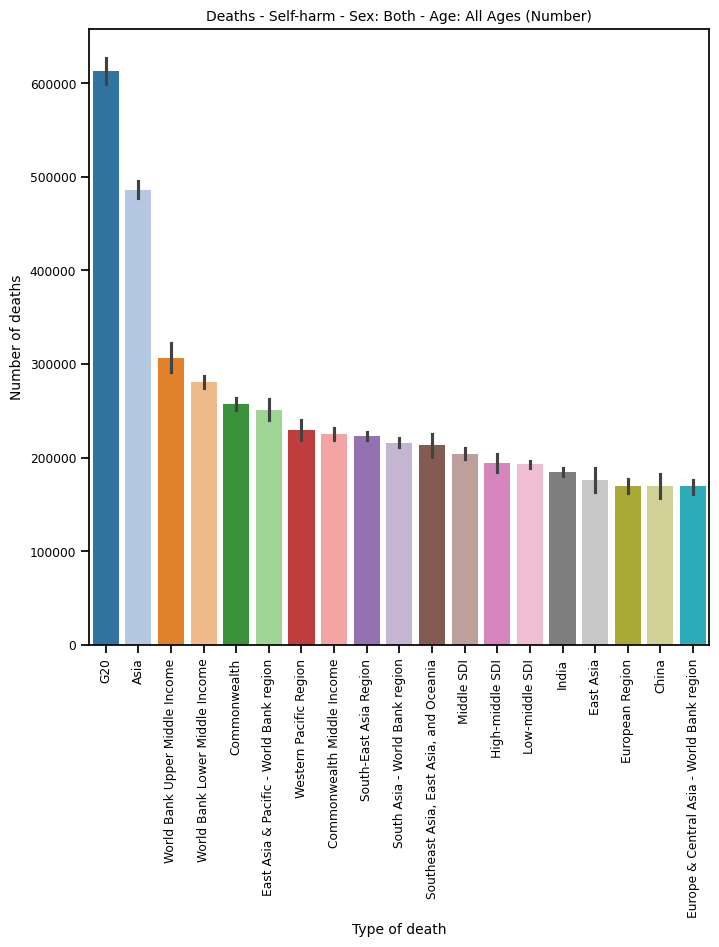

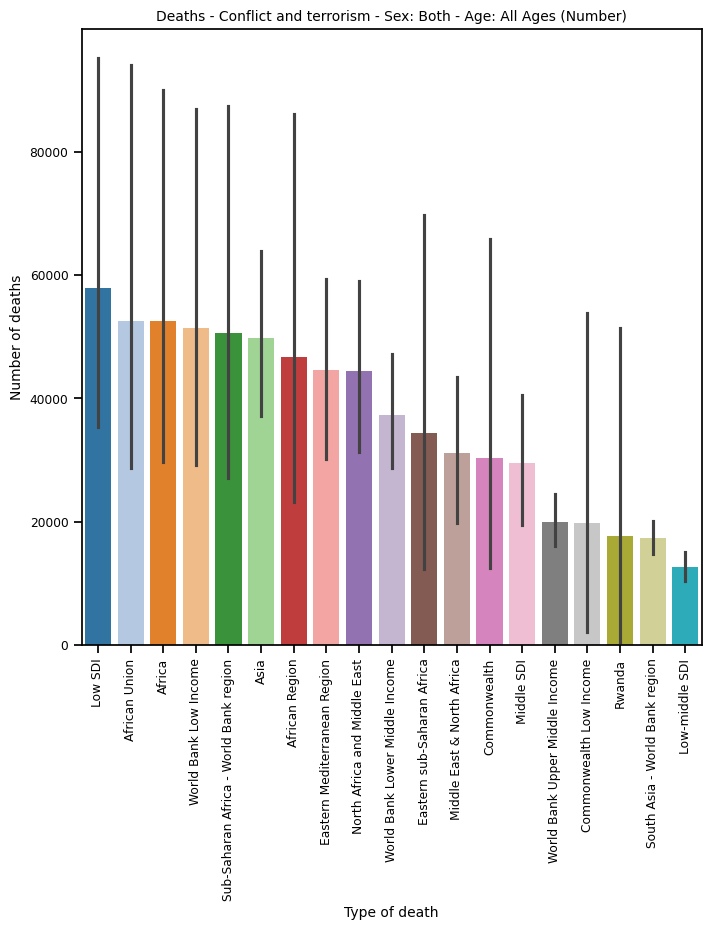

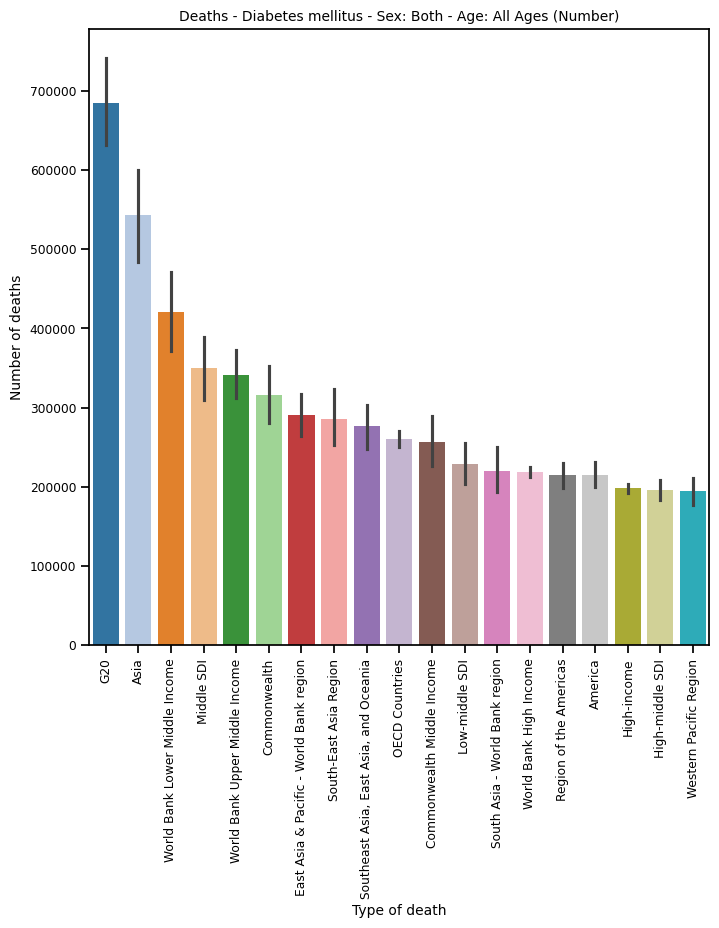

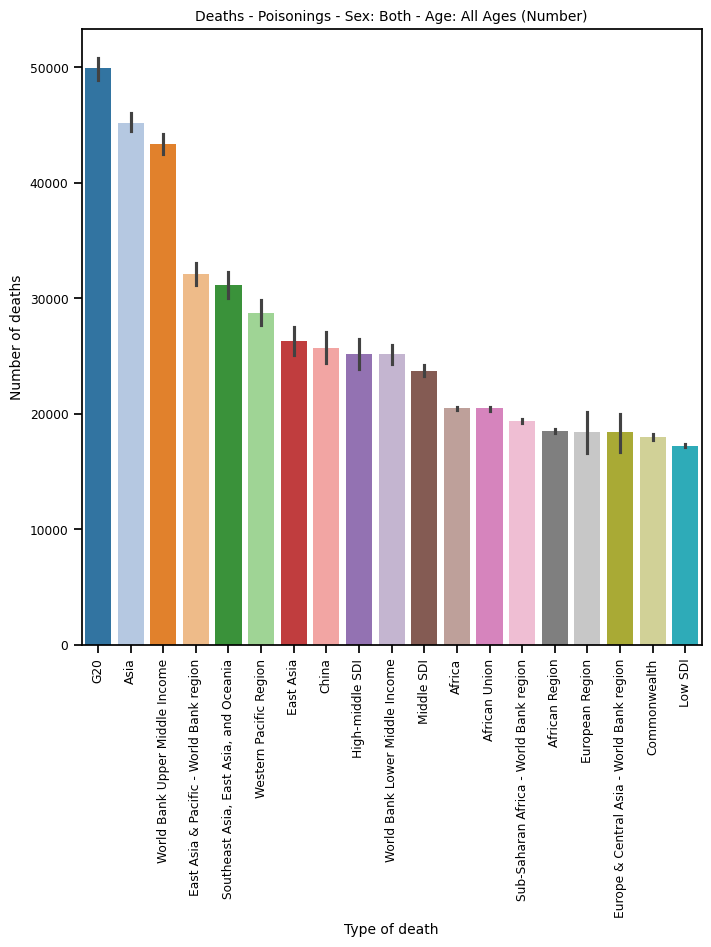

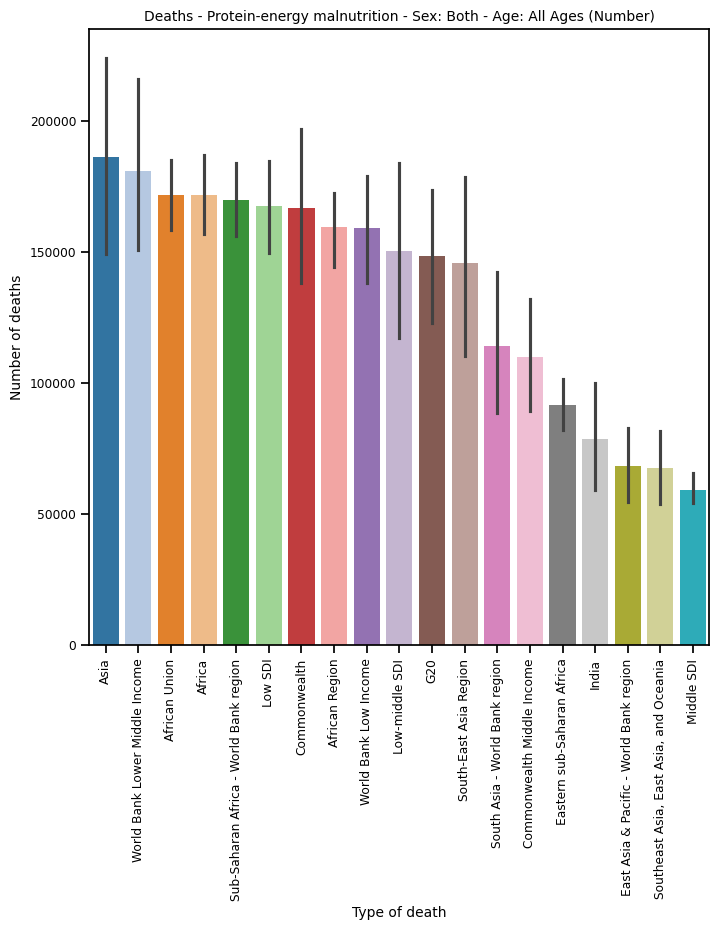

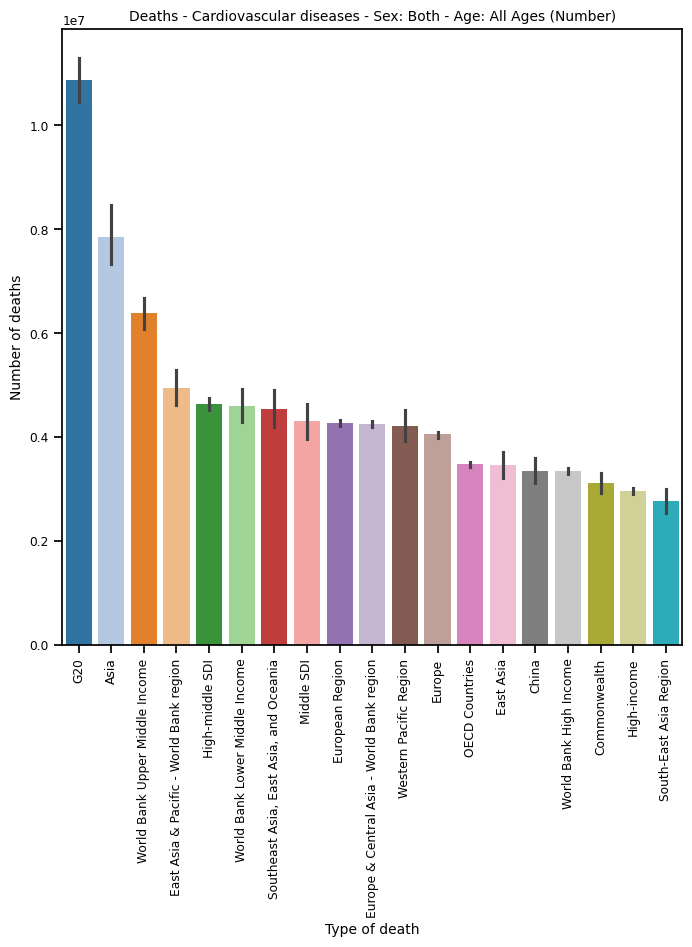

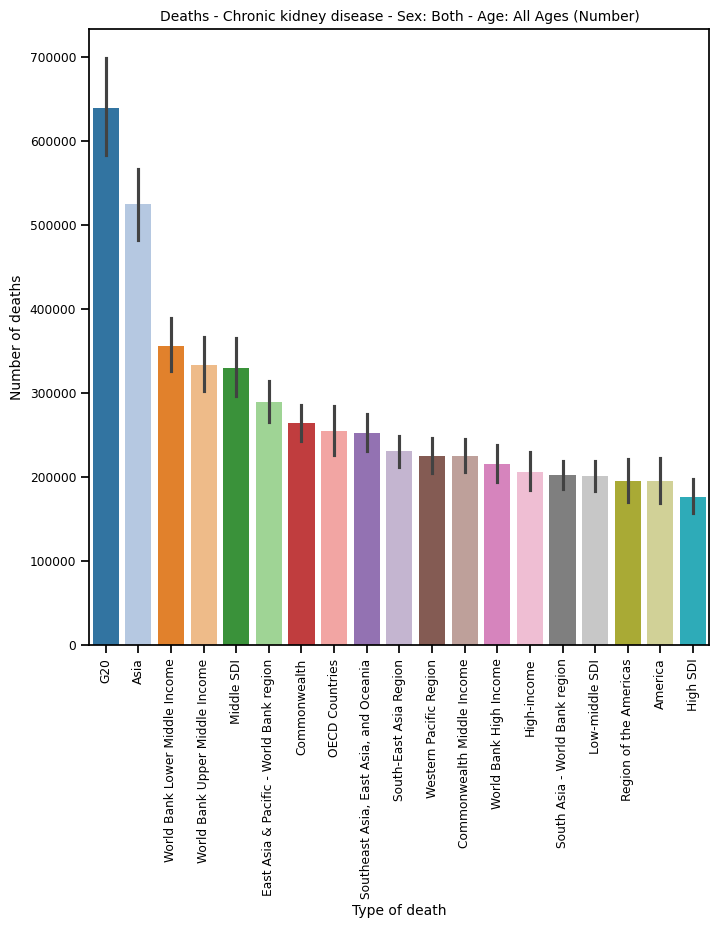

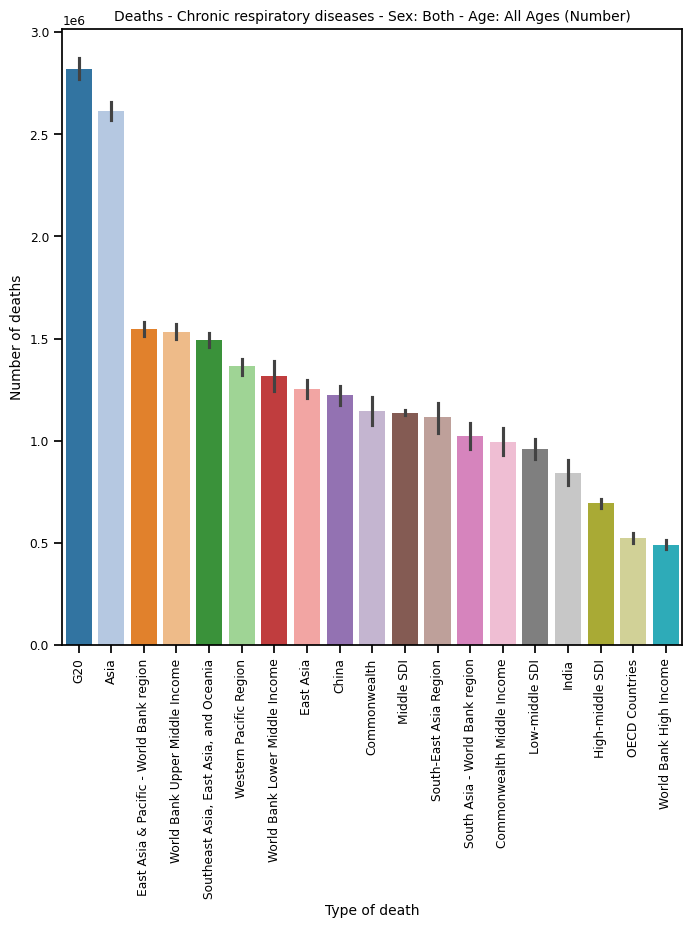

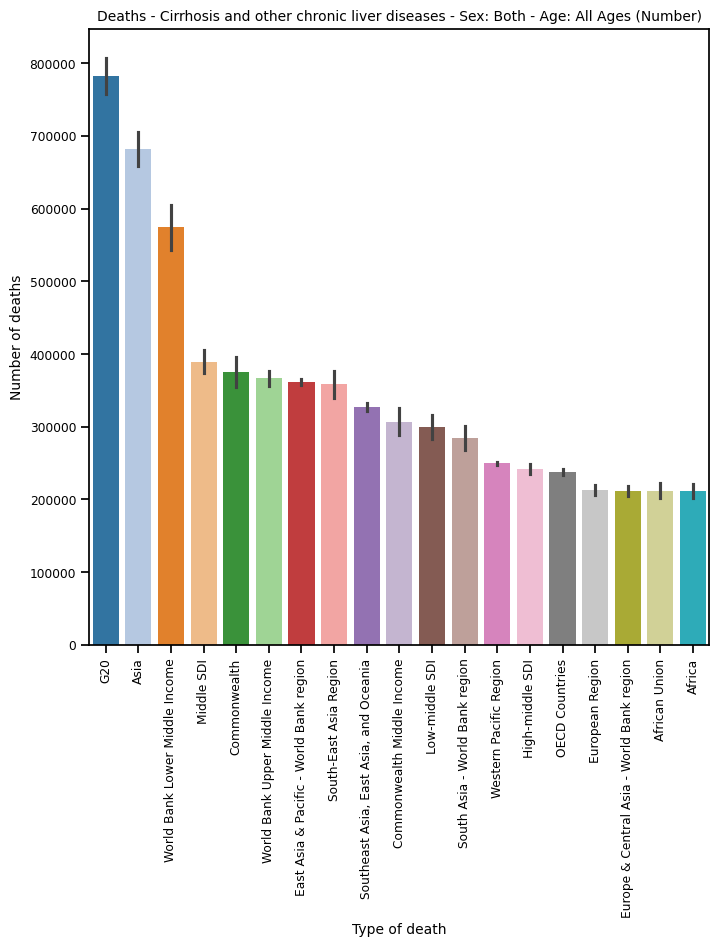

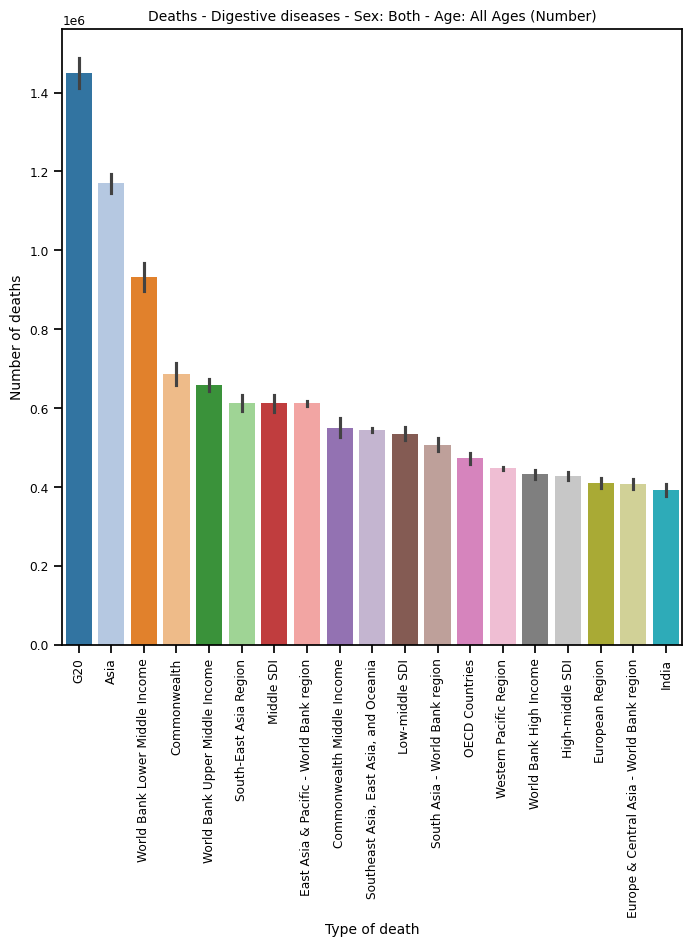

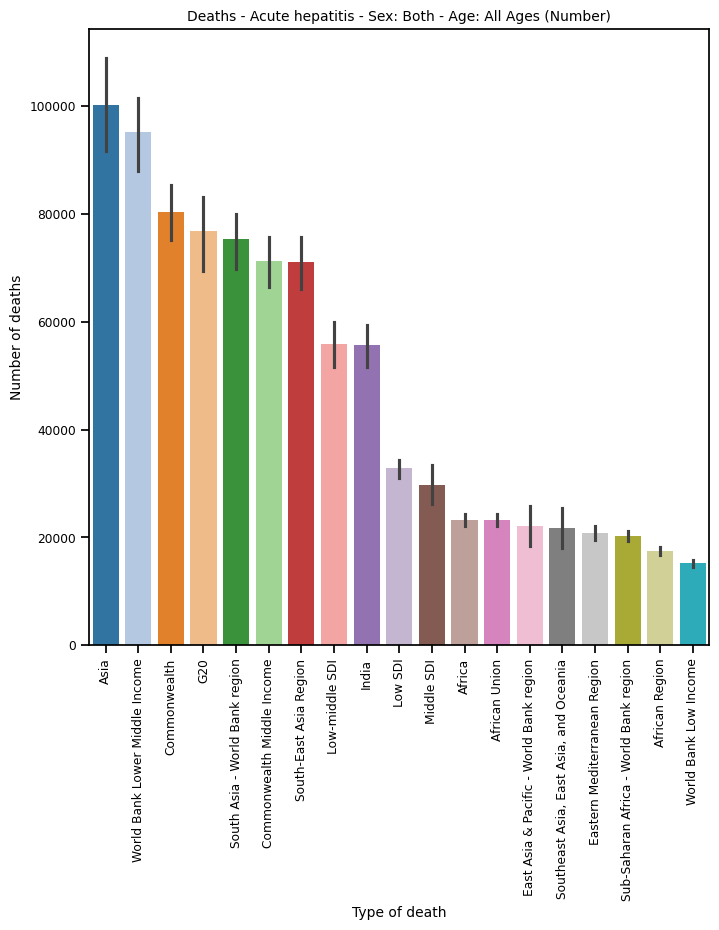

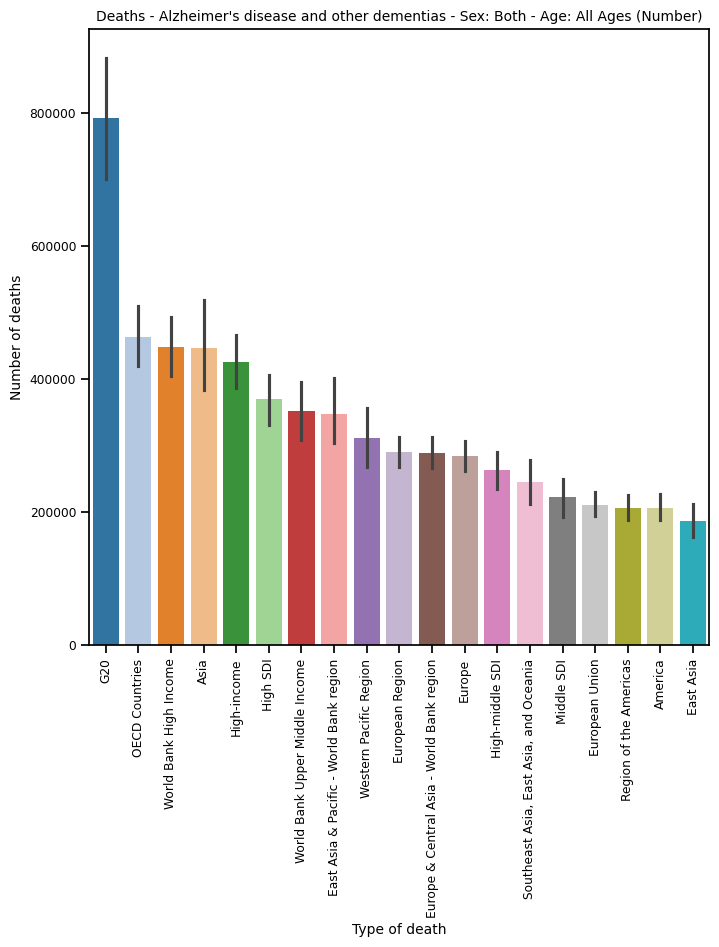

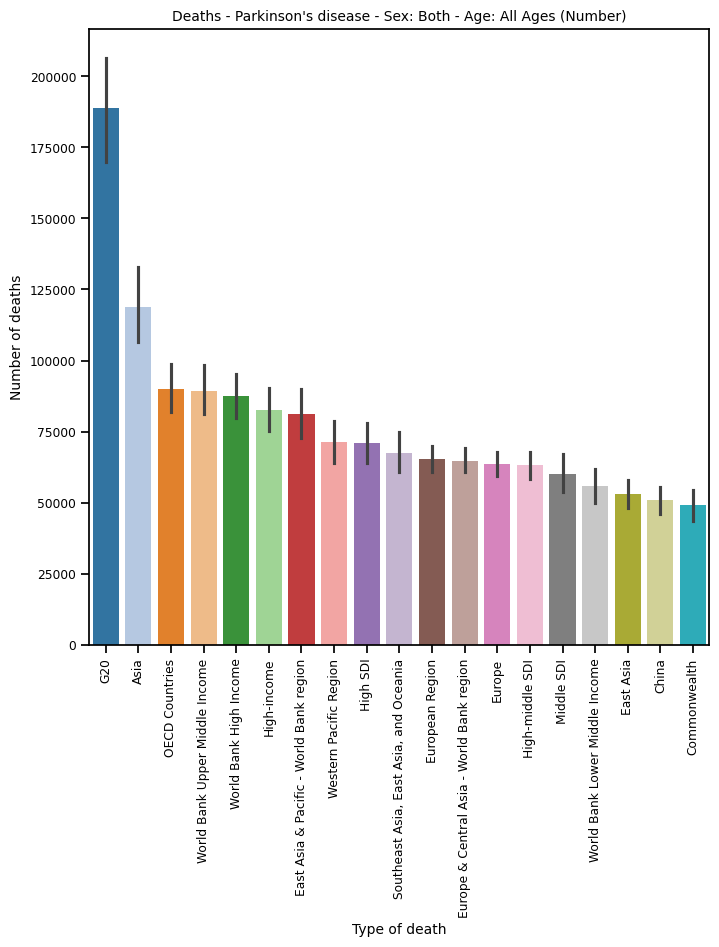

In [69]:
for j in a:
    plot_order = df.groupby('Entity')[j].sum().sort_values(ascending=False).index.values
    sns.set_context('notebook', font_scale=0.8)
    plt.figure(figsize=(8, 8))
    sns.barplot(x="Entity", y=j, data=df, palette='tab20', order=plot_order[1:20])
    plt.title(j, size=10)
    plt.ylabel('Number of deaths', size=10)
    plt.xlabel('Type of death', size=10)
    plt.xticks(rotation=90)

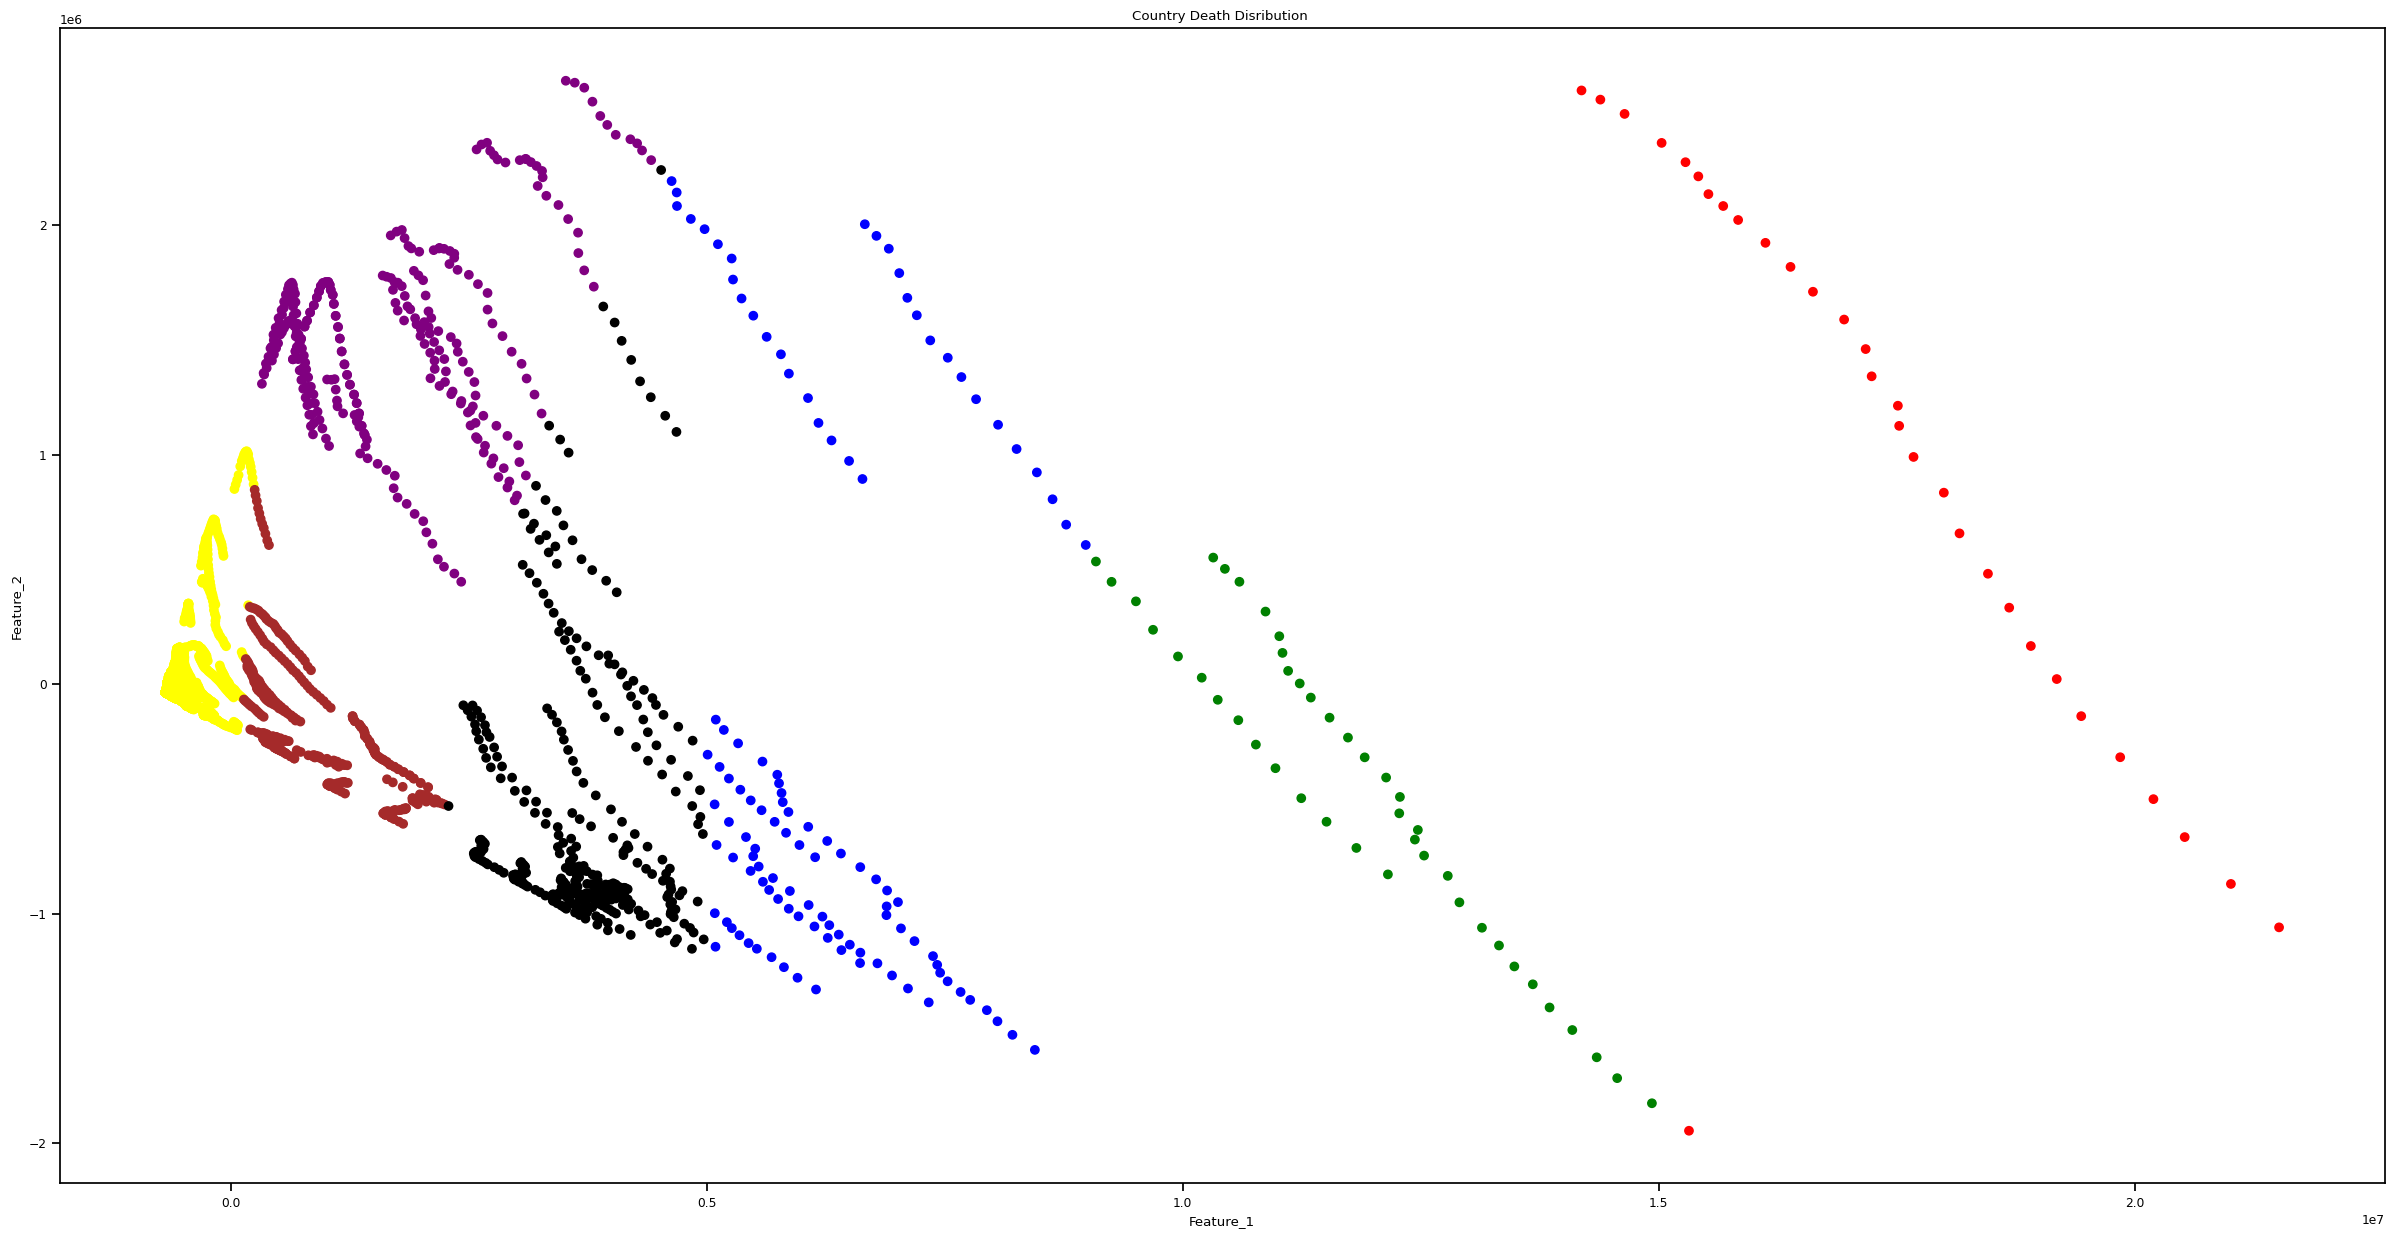

In [70]:
kmeans = KMeans(n_clusters=7)
k_fit = kmeans.fit(df[num_val])
clusters = kmeans.labels_
df["Class"]=clusters
df = pd.DataFrame(df)
df.head()



pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[num_val])
df_pca=pd.DataFrame(data=df_pca,columns=["Feature_1","Feature_2"])
df_pca["Entity"]=df["Entity"]

kmeans = KMeans(n_clusters=7)
k_fit = kmeans.fit(df_pca[["Feature_1","Feature_2"]])

clusters = kmeans.labels_
df_pca["Entity"]=clusters
df_pca = pd.DataFrame(df_pca)
df_pca.head()



colors = {0:'yellow', 1:'blue', 2:'green', 3:'black', 4:'red', 5:'purple', 6:'brown'}
plt.figure(figsize=(30,15))
plt.scatter(df_pca["Feature_1"],df_pca["Feature_2"],c=df_pca['Entity'].map(colors))
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.title("Country Death Disribution ")
plt.show()